# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 2  
data_points_exp = 20000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([20000, 2]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 138.05557250976562
iteration 0 loss 956.428955078125


iteration 500 loss 1.1512197256088257


iteration 1000 loss 0.07078554481267929


iteration 1500 loss 0.03850073739886284


iteration 2000 loss 0.024842876940965652


iteration 2500 loss 0.016623275354504585


iteration 3000 loss 0.01224892120808363


iteration 3500 loss 0.009121247567236423


iteration 4000 loss 0.0069312057457864285


iteration 4500 loss 0.00645181629806757


iteration 5000 loss 0.00451259920373559


iteration 5500 loss 0.003490005386993289


iteration 6000 loss 0.004707008134573698


iteration 6500 loss 0.0024875220842659473


iteration 7000 loss 0.0019084744853898883


iteration 7500 loss 0.0019258727552369237


iteration 8000 loss 0.0014027439756318927


iteration 8500 loss 0.002198980888351798


iteration 9000 loss 0.0011593842646107078


iteration 9500 loss 0.0008881755638867617


iteration 10000 loss 0.0010353757534176111


iteration 10500 loss 0.0007095934124663472


iteration 11000 loss 0.0008685850189067423


iteration 11500 loss 0.0005499343969859183


iteration 12000 loss 0.0006266512791626155


iteration 12500 loss 0.00044741973397322


iteration 13000 loss 0.000575854501221329


iteration 13500 loss 0.0003814483934547752


iteration 14000 loss 0.0005064813303761184


iteration 14500 loss 0.00032718770671635866


iteration 15000 loss 0.00045103824231773615


iteration 15500 loss 0.0002841865934897214


iteration 16000 loss 0.0003260047815274447


iteration 16500 loss 0.0004340098239481449


iteration 17000 loss 0.00022635883942712098


iteration 17500 loss 0.0002500344126019627


iteration 18000 loss 0.0005233582342043519


iteration 18500 loss 0.00019477141904644668


iteration 19000 loss 0.0002191989915445447


iteration 19500 loss 0.00195645191706717


iteration 20000 loss 0.00017121434211730957


iteration 20500 loss 0.0001897474139695987


iteration 21000 loss 0.00023485967540182173


iteration 21500 loss 0.0001407659874530509


iteration 22000 loss 0.0001441771164536476


iteration 22500 loss 0.00015929526125546545


iteration 23000 loss 0.00025945762172341347


iteration 23500 loss 0.0001198557365569286


iteration 24000 loss 0.00015433777298312634


iteration 24500 loss 0.00010682725405786186


iteration 25000 loss 0.00011932756751775742


iteration 25500 loss 0.00013487796240951866


iteration 26000 loss 0.004825543146580458


iteration 26500 loss 0.00010529810970183462


iteration 27000 loss 0.00014799268683418632


iteration 27500 loss 9.074089030036703e-05


iteration 28000 loss 0.00011069077299907804


iteration 28500 loss 7.957602792885154e-05


iteration 29000 loss 9.047523781191558e-05


iteration 29500 loss 0.00011415404878789559


iteration 30000 loss 7.675120286876336e-05


iteration 30500 loss 0.00010067376570077613


iteration 31000 loss 7.310778892133385e-05


iteration 31500 loss 8.399094076594338e-05


iteration 32000 loss 9.952825348591432e-05


iteration 32500 loss 6.74960610922426e-05


iteration 33000 loss 7.706820906605572e-05


iteration 33500 loss 0.00012518496077973396


iteration 34000 loss 6.578968896064907e-05


iteration 34500 loss 8.503572462359443e-05


iteration 35000 loss 6.089845919632353e-05


iteration 35500 loss 6.913107790751383e-05


iteration 36000 loss 7.989988807821646e-05


iteration 36500 loss 0.022984609007835388


iteration 37000 loss 6.16412507952191e-05


iteration 37500 loss 0.00017800564819481224


iteration 38000 loss 5.733823127229698e-05


iteration 38500 loss 9.524212509859353e-05


iteration 39000 loss 5.341442738426849e-05


iteration 39500 loss 6.91862587700598e-05


iteration 40000 loss 4.9362668505636975e-05


iteration 40500 loss 6.730383756803349e-05


iteration 41000 loss 4.854342114413157e-05


iteration 41500 loss 5.276079536997713e-05


iteration 42000 loss 8.242389594670385e-05


iteration 42500 loss 5.1334587624296546e-05


iteration 43000 loss 0.0001477094629080966


iteration 43500 loss 4.937251651426777e-05


iteration 44000 loss 5.606778722722083e-05


iteration 44500 loss 0.001220201258547604


iteration 45000 loss 5.154026439413428e-05


iteration 45500 loss 0.00018930103396996856


iteration 46000 loss 4.77292705909349e-05


iteration 46500 loss 5.851537935086526e-05


iteration 47000 loss 4.2431125621078536e-05


iteration 47500 loss 5.040952964918688e-05


iteration 48000 loss 0.0006021607550792396


iteration 48500 loss 4.826354415854439e-05


iteration 49000 loss 0.0034692687913775444


iteration 49500 loss 4.5189273805590346e-05


iteration 50000 loss 5.375002365326509e-05


iteration 50500 loss 0.46355482935905457


iteration 51000 loss 4.689741399488412e-05


iteration 51500 loss 0.000543412403203547


iteration 52000 loss 4.44203797087539e-05


iteration 52500 loss 7.143742550397292e-05


iteration 53000 loss 0.00024340995878446847


iteration 53500 loss 4.033562072436325e-05


iteration 54000 loss 5.17271037097089e-05


iteration 54500 loss 0.0049786027520895


iteration 55000 loss 4.001619163318537e-05


iteration 55500 loss 5.378354762797244e-05


iteration 56000 loss 0.0001830288820201531


iteration 56500 loss 3.763431959669106e-05


iteration 57000 loss 4.689608613261953e-05


iteration 57500 loss 5.606032573268749e-05


iteration 58000 loss 3.452792589087039e-05


iteration 58500 loss 4.103521496290341e-05


iteration 59000 loss 4.869612166658044e-05


iteration 59500 loss 7.683748117415234e-05


iteration 60000 loss 3.502074832795188e-05


iteration 60500 loss 4.173979687038809e-05


iteration 61000 loss 5.099744157632813e-05


iteration 61500 loss 3.338165697641671e-05


iteration 62000 loss 3.905058838427067e-05


iteration 62500 loss 5.618075010715984e-05


iteration 63000 loss 3.4196269552921876e-05


iteration 63500 loss 3.9091657527023926e-05


iteration 64000 loss 3.75888921553269e-05


iteration 64500 loss 4.3173098674742505e-05


iteration 65000 loss 0.0007351008243858814


iteration 65500 loss 0.019595684483647346


iteration 66000 loss 3.3299762435490265e-05


iteration 66500 loss 4.9673766625346616e-05


iteration 67000 loss 3.1304374715546146e-05


iteration 67500 loss 9.574340947438031e-05


iteration 68000 loss 3.165539601468481e-05


iteration 68500 loss 3.13371310767252e-05


iteration 69000 loss 3.6862114939140156e-05


iteration 69500 loss 2.82698092632927e-05


iteration 70000 loss 3.107650627498515e-05


iteration 70500 loss 3.674955223686993e-05


iteration 71000 loss 2.804951509460807e-05


iteration 71500 loss 3.088334415224381e-05


iteration 72000 loss 3.464652763796039e-05


iteration 72500 loss 2.9491015084204264e-05


iteration 73000 loss 3.613263470469974e-05


iteration 73500 loss 2.6861351216211915e-05


iteration 74000 loss 3.000475771841593e-05


iteration 74500 loss 3.655206455732696e-05


iteration 75000 loss 2.6071362299262546e-05


iteration 75500 loss 2.85092737613013e-05


iteration 76000 loss 4.090756192454137e-05


iteration 76500 loss 2.5636803911766037e-05


iteration 77000 loss 2.7298630811856128e-05


iteration 77500 loss 2.9630424251081422e-05


iteration 78000 loss 7.888484105933458e-05


iteration 78500 loss 2.556054460001178e-05


iteration 79000 loss 3.1403837056132033e-05


iteration 79500 loss 2.4091721570584923e-05


iteration 80000 loss 2.6308080123271793e-05


iteration 80500 loss 3.7196004996076226e-05


iteration 81000 loss 2.4261962607852183e-05


iteration 81500 loss 3.47531822626479e-05


iteration 82000 loss 2.400643097644206e-05


iteration 82500 loss 3.0541763408109546e-05


iteration 83000 loss 2.2800773876952007e-05


iteration 83500 loss 2.5653447664808482e-05


iteration 84000 loss 4.9358379328623414e-05


iteration 84500 loss 2.3309352400247008e-05


iteration 85000 loss 3.1764582672622055e-05


iteration 85500 loss 2.2433516278397292e-05


iteration 86000 loss 3.168151306454092e-05


iteration 86500 loss 2.2364270989783108e-05


iteration 87000 loss 2.5572191589162685e-05


iteration 87500 loss 4.9696594942361116e-05


iteration 88000 loss 2.2224807253223844e-05


iteration 88500 loss 2.53091384365689e-05


iteration 89000 loss 5.679579408024438e-05


iteration 89500 loss 2.180366027459968e-05


iteration 90000 loss 2.5123894374701194e-05


iteration 90500 loss 0.0060710846446454525


iteration 91000 loss 2.213918196503073e-05


iteration 91500 loss 2.6397352485219017e-05


iteration 92000 loss 0.07877341657876968


iteration 92500 loss 2.1921916413703002e-05


iteration 93000 loss 2.9986476874910295e-05


iteration 93500 loss 2.062153180304449e-05


iteration 94000 loss 2.215966014773585e-05


iteration 94500 loss 2.4196853701141663e-05


iteration 95000 loss 4.813185296370648e-05


iteration 95500 loss 2.0171080905129202e-05


iteration 96000 loss 2.211716491729021e-05


iteration 96500 loss 0.00010662059503374621


iteration 97000 loss 1.9885819710907526e-05


iteration 97500 loss 2.0542629499686882e-05


iteration 98000 loss 2.1467609258252196e-05


iteration 98500 loss 2.3115311705623753e-05


iteration 99000 loss 3.0208986572688445e-05


iteration 99500 loss 1.899999006127473e-05


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 1.9546361727407202e-05


iteration 100500 loss 1.922662886499893e-05


iteration 101000 loss 1.887125472421758e-05


iteration 101500 loss 1.8474795069778338e-05


iteration 102000 loss 1.8030908904620446e-05


iteration 102500 loss 1.753712786012329e-05


iteration 103000 loss 1.7004465917125344e-05


iteration 103500 loss 1.6443424101453274e-05


iteration 104000 loss 1.5847128452151082e-05


iteration 104500 loss 1.5203144357656129e-05


iteration 105000 loss 1.4679213563795201e-05


iteration 105500 loss 1.4221761375665665e-05


iteration 106000 loss 1.3705819583265111e-05


iteration 106500 loss 1.3363222024054267e-05


iteration 107000 loss 1.2932303434354253e-05


iteration 107500 loss 1.2607526514329948e-05


iteration 108000 loss 1.2240185242262669e-05


iteration 108500 loss 1.1922458725166507e-05


iteration 109000 loss 1.1603232451307122e-05


iteration 109500 loss 0.00015182592323981225


iteration 110000 loss 1.1024121704394929e-05


iteration 110500 loss 1.071715360012604e-05


iteration 111000 loss 1.0503383236937225e-05


iteration 111500 loss 1.0250879313389305e-05


iteration 112000 loss 1.0022830792877357e-05


iteration 112500 loss 9.81465564109385e-06


iteration 113000 loss 9.59172029979527e-06


iteration 113500 loss 9.411217433807906e-06


iteration 114000 loss 1.065092692442704e-05


iteration 114500 loss 9.023521670314949e-06


iteration 115000 loss 8.862252798280679e-06


iteration 115500 loss 9.981527909985743e-06


iteration 116000 loss 8.5282044892665e-06


iteration 116500 loss 8.38142295833677e-06


iteration 117000 loss 0.0008926813607104123


iteration 117500 loss 8.082586646196432e-06


iteration 118000 loss 7.947886842885055e-06


iteration 118500 loss 7.792399628669955e-06


iteration 119000 loss 7.684800948482007e-06


iteration 119500 loss 8.173787136911415e-06


iteration 120000 loss 7.438929969794117e-06


iteration 120500 loss 7.327913408516906e-06


iteration 121000 loss 7.196403203124646e-06


iteration 121500 loss 7.102428298821906e-06


iteration 122000 loss 0.00013972038868814707


iteration 122500 loss 6.893033969390672e-06


iteration 123000 loss 6.813451363996137e-06


iteration 123500 loss 6.691324415442068e-06


iteration 124000 loss 6.606501301575918e-06


iteration 124500 loss 6.500909421447432e-06


iteration 125000 loss 6.419529654522194e-06


iteration 125500 loss 6.338277216855204e-06


iteration 126000 loss 6.235694399947533e-06


iteration 126500 loss 6.156223662401317e-06


iteration 127000 loss 6.078577825974207e-06


iteration 127500 loss 8.43798989080824e-06


iteration 128000 loss 5.912874712521443e-06


iteration 128500 loss 5.843143298989162e-06


iteration 129000 loss 5.778472313977545e-06


iteration 129500 loss 5.690522357326699e-06


iteration 130000 loss 5.628844974125968e-06


iteration 130500 loss 5.5683835853415076e-06


iteration 131000 loss 5.485898782353615e-06


iteration 131500 loss 5.431419140222715e-06


iteration 132000 loss 5.374528882384766e-06


iteration 132500 loss 5.300559223542223e-06


iteration 133000 loss 5.24491360920365e-06


iteration 133500 loss 5.1903416533605196e-06


iteration 134000 loss 5.123269602336222e-06


iteration 134500 loss 5.073789452580968e-06


iteration 135000 loss 5.026146482123295e-06


iteration 135500 loss 4.961590548191452e-06


iteration 136000 loss 4.91537912239437e-06


iteration 136500 loss 4.882910616288427e-06


iteration 137000 loss 4.810956852452364e-06


iteration 137500 loss 4.767315203935141e-06


iteration 138000 loss 3.7787871406180784e-05


iteration 138500 loss 4.670910584536614e-06


iteration 139000 loss 4.635161985788727e-06


iteration 139500 loss 4.583477675623726e-06


iteration 140000 loss 4.552205609797966e-06


iteration 140500 loss 4.50276593255694e-06


iteration 141000 loss 4.477038146433188e-06


iteration 141500 loss 4.427740350365639e-06


iteration 142000 loss 9.96562357613584e-06


iteration 142500 loss 4.344372882769676e-06


iteration 143000 loss 4.307794824853772e-06


iteration 143500 loss 4.271918896847637e-06


iteration 144000 loss 0.001440990250557661


iteration 144500 loss 4.190515028312802e-06


iteration 145000 loss 4.156758677709149e-06


iteration 145500 loss 4.124393853999209e-06


iteration 146000 loss 4.082723989995429e-06


iteration 146500 loss 4.049172275699675e-06


iteration 147000 loss 4.016268121631583e-06


iteration 147500 loss 3.985334842582233e-06


iteration 148000 loss 4.212133262626594e-06


iteration 148500 loss 3.915371962648351e-06


iteration 149000 loss 3.887098500854336e-06


iteration 149500 loss 3.859475782519439e-06


iteration 150000 loss 7.580561941722408e-06


iteration 150500 loss 3.7917418467259267e-06


iteration 151000 loss 3.7658151086361613e-06


iteration 151500 loss 3.7402658108476317e-06


iteration 152000 loss 0.00011780850763898343


iteration 152500 loss 3.67980146620539e-06


iteration 153000 loss 3.6554708913172362e-06


iteration 153500 loss 3.6520905268844217e-06


iteration 154000 loss 3.597288468881743e-06


iteration 154500 loss 3.5744278648053296e-06


iteration 155000 loss 3.5499735986377345e-06


iteration 155500 loss 3.5305517940287245e-06


iteration 156000 loss 0.0002868564042728394


iteration 156500 loss 3.4699696698226035e-06


iteration 157000 loss 3.4495378713472746e-06


iteration 157500 loss 3.4310048704355722e-06


iteration 158000 loss 3.398467924853321e-06


iteration 158500 loss 3.3801502468122635e-06


iteration 159000 loss 3.3613703180890298e-06


iteration 159500 loss 3.330137587909121e-06


iteration 160000 loss 3.3098906442319276e-06


iteration 160500 loss 3.2906657452258514e-06


iteration 161000 loss 3.271386276537669e-06


iteration 161500 loss 3.243092805860215e-06


iteration 162000 loss 3.2259299587167334e-06


iteration 162500 loss 3.2087309591588564e-06


iteration 163000 loss 3.1833037610340398e-06


iteration 163500 loss 3.165621592415846e-06


iteration 164000 loss 3.149670192215126e-06


iteration 164500 loss 3.1236772883858066e-06


iteration 165000 loss 3.1089005005924264e-06


iteration 165500 loss 3.0950611744628986e-06


iteration 166000 loss 3.0699595754413167e-06


iteration 166500 loss 3.0571147817681776e-06


iteration 167000 loss 3.0332371352415066e-06


iteration 167500 loss 3.0200676519598346e-06


iteration 168000 loss 3.0149622034514323e-06


iteration 168500 loss 2.9824250304955058e-06


iteration 169000 loss 2.970239165733801e-06


iteration 169500 loss 2.947277607745491e-06


iteration 170000 loss 2.9362552140810294e-06


iteration 170500 loss 8.88071081135422e-05


iteration 171000 loss 2.9047200769127812e-06


iteration 171500 loss 0.0002658384037204087


iteration 172000 loss 2.874214032999589e-06


iteration 172500 loss 0.000982312485575676


iteration 173000 loss 2.8449569526856067e-06


iteration 173500 loss 2.823661361617269e-06


iteration 174000 loss 2.8163649403722957e-06


iteration 174500 loss 2.796841272356687e-06


iteration 175000 loss 2.788768370010075e-06


iteration 175500 loss 2.7690666684065945e-06


iteration 176000 loss 2.7603541639109608e-06


iteration 176500 loss 2.7415180738898925e-06


iteration 177000 loss 2.732984739850508e-06


iteration 177500 loss 2.7141484224557644e-06


iteration 178000 loss 2.706080977077363e-06


iteration 178500 loss 2.687477262952598e-06


iteration 179000 loss 2.681574869711767e-06


iteration 179500 loss 2.663575060068979e-06


iteration 180000 loss 2.6560255719232373e-06


iteration 180500 loss 2.6379852897662204e-06


iteration 181000 loss 2.631623601700994e-06


iteration 181500 loss 2.614462346173241e-06


iteration 182000 loss 2.6092209282069234e-06


iteration 182500 loss 2.590385292933206e-06


iteration 183000 loss 2.5902111246978166e-06


iteration 183500 loss 2.567742967585218e-06


iteration 184000 loss 2.5502706648694584e-06


iteration 184500 loss 2.546152700233506e-06


iteration 185000 loss 2.529370703996392e-06


iteration 185500 loss 2.5210615604009945e-06


iteration 186000 loss 3.6283954614191316e-06


iteration 186500 loss 2.4958476387837436e-06


iteration 187000 loss 2.4877081159502268e-06


iteration 187500 loss 2.4712189770070836e-06


iteration 188000 loss 2.4642345124448184e-06


iteration 188500 loss 2.52052836913208e-06


iteration 189000 loss 2.438893034195644e-06


iteration 189500 loss 2.4294467948493548e-06


iteration 190000 loss 2.4192954697355162e-06


iteration 190500 loss 2.4427074549748795e-06


iteration 191000 loss 2.3931870600790717e-06


iteration 191500 loss 2.384014351264341e-06


iteration 192000 loss 2.37462359109486e-06


iteration 192500 loss 2.366116177654476e-06


iteration 193000 loss 2.3508791855419986e-06


iteration 193500 loss 2.3421753212460317e-06


iteration 194000 loss 2.332443045816035e-06


iteration 194500 loss 2.322653699593502e-06


iteration 195000 loss 2.313706545464811e-06


iteration 195500 loss 9.8212985903956e-06


iteration 196000 loss 2.289681106049102e-06


iteration 196500 loss 2.28053090722824e-06


iteration 197000 loss 2.2718566015100805e-06


iteration 197500 loss 2.263197984575527e-06


iteration 198000 loss 2.2551917027158197e-06


iteration 198500 loss 0.0003463153843767941


iteration 199000 loss 2.231991857115645e-06


iteration 199500 loss 2.2234810330701293e-06


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 2.2147171421238454e-06


iteration 200500 loss 2.2133106085675536e-06


iteration 201000 loss 2.2115555111668073e-06


iteration 201500 loss 2.2094673113315366e-06


iteration 202000 loss 2.2066278688726015e-06


iteration 202500 loss 2.2031251774023985e-06


iteration 203000 loss 2.198593620050815e-06


iteration 203500 loss 2.1926825866103172e-06


iteration 204000 loss 2.1853147700312547e-06


iteration 204500 loss 2.175934923798195e-06


iteration 205000 loss 2.164071474908269e-06


iteration 205500 loss 2.1562352685577935e-06


iteration 206000 loss 2.1468192699103383e-06


iteration 206500 loss 2.1347584606701275e-06


iteration 207000 loss 2.128540700141457e-06


iteration 207500 loss 2.1211139937804546e-06


iteration 208000 loss 2.111705498464289e-06


iteration 208500 loss 2.102513690260821e-06


iteration 209000 loss 2.094298224619706e-06


iteration 209500 loss 2.0849911379627883e-06


iteration 210000 loss 2.0760217012139037e-06


iteration 210500 loss 2.067615469059092e-06


iteration 211000 loss 2.0569161733874353e-06


iteration 211500 loss 2.0501172457443317e-06


iteration 212000 loss 2.041395418928005e-06


iteration 212500 loss 2.0323343505879166e-06


iteration 213000 loss 2.024330797212315e-06


iteration 213500 loss 2.014603069255827e-06


iteration 214000 loss 2.0076706732652383e-06


iteration 214500 loss 2.0003340068797115e-06


iteration 215000 loss 1.9909257389372215e-06


iteration 215500 loss 1.98348652702407e-06


iteration 216000 loss 1.9752312709897524e-06


iteration 216500 loss 1.9668443655973533e-06


iteration 217000 loss 1.9594754121499136e-06


iteration 217500 loss 1.950463911271072e-06


iteration 218000 loss 1.9434596651990432e-06


iteration 218500 loss 1.9354013147676596e-06


iteration 219000 loss 1.927367520693224e-06


iteration 219500 loss 1.9198321297153598e-06


iteration 220000 loss 1.9431299733696505e-06


iteration 220500 loss 1.9042595340579282e-06


iteration 221000 loss 1.8957275642605964e-06


iteration 221500 loss 1.889036411739653e-06


iteration 222000 loss 1.880971694845357e-06


iteration 222500 loss 1.8738776361715281e-06


iteration 223000 loss 1.8661598915059585e-06


iteration 223500 loss 1.8589093997434247e-06


iteration 224000 loss 1.8515615920478012e-06


iteration 224500 loss 1.8442664213580429e-06


iteration 225000 loss 1.837040031205106e-06


iteration 225500 loss 1.82981909802038e-06


iteration 226000 loss 1.8228697626909707e-06


iteration 226500 loss 1.8157102203986142e-06


iteration 227000 loss 1.8090378262058948e-06


iteration 227500 loss 5.18427850693115e-06


iteration 228000 loss 1.7952868347492767e-06


iteration 228500 loss 2.4005207706068177e-06


iteration 229000 loss 1.7816103081713663e-06


iteration 229500 loss 1.9866311049554497e-06


iteration 230000 loss 1.7681273902780958e-06


iteration 230500 loss 1.7612597957850085e-06


iteration 231000 loss 1.7552619056004914e-06


iteration 231500 loss 1.7478514564572833e-06


iteration 232000 loss 1.7425096530132578e-06


iteration 232500 loss 1.7358111108478624e-06


iteration 233000 loss 1.7298161765211262e-06


iteration 233500 loss 1.723587615742872e-06


iteration 234000 loss 1.7175295852212003e-06


iteration 234500 loss 1.7115813761847676e-06


iteration 235000 loss 1.7054512682079803e-06


iteration 235500 loss 1.6995765008687158e-06


iteration 236000 loss 3.557762056516367e-06


iteration 236500 loss 1.6875884512046468e-06


iteration 237000 loss 1.6809200360512477e-06


iteration 237500 loss 1.6760900507506449e-06


iteration 238000 loss 1.6701459344403702e-06


iteration 238500 loss 1.6645815321680857e-06


iteration 239000 loss 1.6592239262536168e-06


iteration 239500 loss 5.40422297490295e-06


iteration 240000 loss 1.6482043747600983e-06


iteration 240500 loss 1.6423616671090713e-06


iteration 241000 loss 1.6371294577766093e-06


iteration 241500 loss 1.6316465689669712e-06


iteration 242000 loss 1.6263051065834588e-06


iteration 242500 loss 1.6210980220421334e-06


iteration 243000 loss 1.6156025139935082e-06


iteration 243500 loss 1.610207846169942e-06


iteration 244000 loss 1.60480249178363e-06


iteration 244500 loss 1.5996816955521354e-06


iteration 245000 loss 1.594622403899848e-06


iteration 245500 loss 1.589627117937198e-06


iteration 246000 loss 7.122504484868841e-06


iteration 246500 loss 1.5793850707268575e-06


iteration 247000 loss 1.5736948171252152e-06


iteration 247500 loss 1.5691534827055875e-06


iteration 248000 loss 1.8138583754989668e-06


iteration 248500 loss 1.5595309150739922e-06


iteration 249000 loss 1.5540988442808157e-06


iteration 249500 loss 1.549626517771685e-06


iteration 250000 loss 1.544196720715263e-06


iteration 250500 loss 1.5399485846501193e-06


iteration 251000 loss 1.5345841575253871e-06


iteration 251500 loss 1.5304623275369522e-06


iteration 252000 loss 1.525217612652341e-06


iteration 252500 loss 1.5209433286145213e-06


iteration 253000 loss 3.1552440304949414e-06


iteration 253500 loss 1.5115479072846938e-06


iteration 254000 loss 1.5082649724718067e-06


iteration 254500 loss 1.5024170352262445e-06


iteration 255000 loss 1.4978402305132477e-06


iteration 255500 loss 1.4933436887076823e-06


iteration 256000 loss 1.4888533996781916e-06


iteration 256500 loss 1.4844140423520003e-06


iteration 257000 loss 1.4799128393860883e-06


iteration 257500 loss 1.4755948996025836e-06


iteration 258000 loss 1.471294467592088e-06


iteration 258500 loss 1.4671570625068853e-06


iteration 259000 loss 1.4627457858296111e-06


iteration 259500 loss 1.4585334611183498e-06


iteration 260000 loss 1.4541316204486066e-06


iteration 260500 loss 1.4498456266665016e-06


iteration 261000 loss 1.4458287296292838e-06


iteration 261500 loss 1.441568429072504e-06


iteration 262000 loss 1.4375169712366187e-06


iteration 262500 loss 1.433410147910763e-06


iteration 263000 loss 1.4295103483163984e-06


iteration 263500 loss 1.4253869267122354e-06


iteration 264000 loss 1.4215265764505602e-06


iteration 264500 loss 1.4176520153341698e-06


iteration 265000 loss 1.4135074479781906e-06


iteration 265500 loss 2.4876121642591897e-06


iteration 266000 loss 1.405547095600923e-06


iteration 266500 loss 1.4016745808476117e-06


iteration 267000 loss 1.397838900629722e-06


iteration 267500 loss 1.3940764347353252e-06


iteration 268000 loss 1.3902813407185022e-06


iteration 268500 loss 1.3865003438695567e-06


iteration 269000 loss 1.3828707778884564e-06


iteration 269500 loss 2.320879730177694e-06


iteration 270000 loss 1.3754744259131257e-06


iteration 270500 loss 1.3714204669668106e-06


iteration 271000 loss 1.3682923736269004e-06


iteration 271500 loss 1.364368358736101e-06


iteration 272000 loss 1.3610448377221473e-06


iteration 272500 loss 1.3571896033681696e-06


iteration 273000 loss 1.353922812086239e-06


iteration 273500 loss 1.3502847195923096e-06


iteration 274000 loss 1.346870021734503e-06


iteration 274500 loss 1.3434050742944237e-06


iteration 275000 loss 1.3399668432612089e-06


iteration 275500 loss 1.336666286988475e-06


iteration 276000 loss 1.6042044080677442e-05


iteration 276500 loss 1.3298978274178808e-06


iteration 277000 loss 1.3260656714919605e-06


iteration 277500 loss 1.3232389619588503e-06


iteration 278000 loss 1.3196462305131718e-06


iteration 278500 loss 1.3166348935556016e-06


iteration 279000 loss 1.31321246499283e-06


iteration 279500 loss 1.309955678152619e-06


iteration 280000 loss 1.3065198345429963e-06


iteration 280500 loss 1.3034498351771617e-06


iteration 281000 loss 1.3002056675759377e-06


iteration 281500 loss 1.2969653653271962e-06


iteration 282000 loss 1.2939098041897523e-06


iteration 282500 loss 1.5462965166079812e-05


iteration 283000 loss 1.2877122799181961e-06


iteration 283500 loss 1.2843630656789173e-06


iteration 284000 loss 1.2815128229703987e-06


iteration 284500 loss 1.2784695400114288e-06


iteration 285000 loss 1.2754186400343315e-06


iteration 285500 loss 1.2725006399705308e-06


iteration 286000 loss 1.5222492038446944e-05


iteration 286500 loss 1.266469553229399e-06


iteration 287000 loss 1.2632010566449026e-06


iteration 287500 loss 1.2602096148839337e-06


iteration 288000 loss 8.692851224623155e-06


iteration 288500 loss 1.2544667242764262e-06


iteration 289000 loss 1.2513160072558094e-06


iteration 289500 loss 1.2484151739045046e-06


iteration 290000 loss 2.843123183993157e-06


iteration 290500 loss 1.2426207831595093e-06


iteration 291000 loss 7.1189178925124e-06


iteration 291500 loss 1.2366255077722599e-06


iteration 292000 loss 1.2379136933304835e-06


iteration 292500 loss 1.230626708093041e-06


iteration 293000 loss 1.227941652359732e-06


iteration 293500 loss 1.2250040981598431e-06


iteration 294000 loss 1.2221257748024072e-06


iteration 294500 loss 1.219326009049837e-06


iteration 295000 loss 1.2165484122306225e-06


iteration 295500 loss 1.2139626051066443e-06


iteration 296000 loss 7.673493200854864e-06


iteration 296500 loss 1.2084194622730138e-06


iteration 297000 loss 1.205340140586486e-06


iteration 297500 loss 1.2030041034449823e-06


iteration 298000 loss 1.1999878779533901e-06


iteration 298500 loss 1.197596816382429e-06


iteration 299000 loss 1.194526248582406e-06


iteration 299500 loss 1.1921976010853541e-06


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 1.189216050079267e-06


iteration 300500 loss 1.1888988638020237e-06


iteration 301000 loss 1.1884753803315107e-06


iteration 301500 loss 1.1879352541654953e-06


iteration 302000 loss 1.1872060667883488e-06


iteration 302500 loss 1.1862252904393245e-06


iteration 303000 loss 1.184957454825053e-06


iteration 303500 loss 1.1833296866825549e-06


iteration 304000 loss 1.181243646897201e-06


iteration 304500 loss 1.1785522247009794e-06


iteration 305000 loss 1.1758298796848976e-06


iteration 305500 loss 1.1739716683223378e-06


iteration 306000 loss 1.1715992513927631e-06


iteration 306500 loss 1.3878853906135191e-06


iteration 307000 loss 1.166897618531948e-06


iteration 307500 loss 1.1648400004560244e-06


iteration 308000 loss 1.1621185649346444e-06


iteration 308500 loss 1.1595572004807764e-06


iteration 309000 loss 1.1578709973036894e-06


iteration 309500 loss 1.1555423498066375e-06


iteration 310000 loss 1.1525819445523666e-06


iteration 310500 loss 1.1507712542879744e-06


iteration 311000 loss 1.1488616564747645e-06


iteration 311500 loss 1.146406248153653e-06


iteration 312000 loss 1.1438980891398387e-06


iteration 312500 loss 1.1418222811698797e-06


iteration 313000 loss 1.1391123280191096e-06


iteration 313500 loss 1.13701310056058e-06


iteration 314000 loss 1.1351473858667305e-06


iteration 314500 loss 1.132723468799668e-06


iteration 315000 loss 1.1300605819997145e-06


iteration 315500 loss 1.1285978871455882e-06


iteration 316000 loss 1.1267758281974238e-06


iteration 316500 loss 1.124368736782344e-06


iteration 317000 loss 1.1217568953725277e-06


iteration 317500 loss 1.1201925644854782e-06


iteration 318000 loss 1.1181028867213172e-06


iteration 318500 loss 1.115508894145023e-06


iteration 319000 loss 1.113467419600056e-06


iteration 319500 loss 1.1117459735032753e-06


iteration 320000 loss 1.1094980436610058e-06


iteration 320500 loss 1.1070601431129035e-06


iteration 321000 loss 1.1052447916881647e-06


iteration 321500 loss 1.1029261486328323e-06


iteration 322000 loss 1.1006159184034914e-06


iteration 322500 loss 1.0990949022016139e-06


iteration 323000 loss 1.0970735502269235e-06


iteration 323500 loss 1.0944871746687568e-06


iteration 324000 loss 1.092860884455149e-06


iteration 324500 loss 1.0910046057688305e-06


iteration 325000 loss 1.0886122936426545e-06


iteration 325500 loss 1.0866381217056187e-06


iteration 326000 loss 1.0850694707187358e-06


iteration 326500 loss 1.0830792689375812e-06


iteration 327000 loss 1.0805463261931436e-06


iteration 327500 loss 1.0790769238155917e-06


iteration 328000 loss 1.0773360372695606e-06


iteration 328500 loss 1.0750276260296232e-06


iteration 329000 loss 1.073152816388756e-06


iteration 329500 loss 1.0714682048273971e-06


iteration 330000 loss 1.069302243195125e-06


iteration 330500 loss 1.067137759491743e-06


iteration 331000 loss 1.0656244739948306e-06


iteration 331500 loss 1.0636158549459651e-06


iteration 332000 loss 1.0614239727146924e-06


iteration 332500 loss 1.0598807875794591e-06


iteration 333000 loss 1.0580107527857763e-06


iteration 333500 loss 1.0555773997111828e-06


iteration 334000 loss 1.0541984920564573e-06


iteration 334500 loss 1.052561401593266e-06


iteration 335000 loss 1.0504629699426005e-06


iteration 335500 loss 1.0485548500582809e-06


iteration 336000 loss 1.0470230336068198e-06


iteration 336500 loss 1.0450555691932095e-06


iteration 337000 loss 1.0428727819089545e-06


iteration 337500 loss 1.0414890994070447e-06


iteration 338000 loss 1.0397620826552156e-06


iteration 338500 loss 1.0375675856266753e-06


iteration 339000 loss 1.035960735862318e-06


iteration 339500 loss 1.034473825711757e-06


iteration 340000 loss 1.0325157973056776e-06


iteration 340500 loss 1.0304252100468148e-06


iteration 341000 loss 1.0291596481692977e-06


iteration 341500 loss 1.02747696928418e-06


iteration 342000 loss 1.0253810387439444e-06


iteration 342500 loss 1.023705635816441e-06


iteration 343000 loss 1.0223344588666805e-06


iteration 343500 loss 1.0206706519966247e-06


iteration 344000 loss 1.0184785423916765e-06


iteration 344500 loss 1.017008116832585e-06


iteration 345000 loss 1.0155731615668628e-06


iteration 345500 loss 1.0137248409591848e-06


iteration 346000 loss 1.0116997373188497e-06


iteration 346500 loss 1.0104862440130091e-06


iteration 347000 loss 1.0089077022712445e-06


iteration 347500 loss 1.0068471283375402e-06


iteration 348000 loss 1.0052353900391608e-06


iteration 348500 loss 1.003766783469473e-06


iteration 349000 loss 1.0019160754382028e-06


iteration 349500 loss 1.0002210046877735e-06


iteration 350000 loss 9.988432339014253e-07


iteration 350500 loss 9.970482324206387e-07


iteration 351000 loss 9.950725825547124e-07


iteration 351500 loss 9.937899676515372e-07


iteration 352000 loss 9.922217714120052e-07


iteration 352500 loss 9.901992825689376e-07


iteration 353000 loss 9.88823330771993e-07


iteration 353500 loss 9.874910347207333e-07


iteration 354000 loss 9.857998293227865e-07


iteration 354500 loss 9.888823342407704e-07


iteration 355000 loss 9.825575943978038e-07


iteration 355500 loss 9.812332564251847e-07


iteration 356000 loss 9.795051028049784e-07


iteration 356500 loss 9.777722880244255e-07


iteration 357000 loss 9.765651611814974e-07


iteration 357500 loss 9.750681329023791e-07


iteration 358000 loss 9.731196541906684e-07


iteration 358500 loss 9.717147122501046e-07


iteration 359000 loss 9.704288004286354e-07


iteration 359500 loss 9.688336604085634e-07


iteration 360000 loss 9.877552429315983e-07


iteration 360500 loss 9.657524060457945e-07


iteration 361000 loss 9.643351859267568e-07


iteration 361500 loss 9.625887287256774e-07


iteration 362000 loss 9.609054814063711e-07


iteration 362500 loss 9.598537644706084e-07


iteration 363000 loss 9.5847849479469e-07


iteration 363500 loss 9.566970220475923e-07


iteration 364000 loss 9.551066568747046e-07


iteration 364500 loss 9.539803613733966e-07


iteration 365000 loss 9.524983966002765e-07


iteration 365500 loss 9.50606533933751e-07


iteration 366000 loss 9.493959964856913e-07


iteration 366500 loss 9.481665301791509e-07


iteration 367000 loss 9.46543138979905e-07


iteration 367500 loss 9.453645475332451e-07


iteration 368000 loss 9.437072776563582e-07


iteration 368500 loss 9.423544611308898e-07


iteration 369000 loss 9.406712706550024e-07


iteration 369500 loss 9.391874868924788e-07


iteration 370000 loss 9.381771519656468e-07


iteration 370500 loss 9.368189353153866e-07


iteration 371000 loss 9.350703749078093e-07


iteration 371500 loss 9.337085202787421e-07


iteration 372000 loss 9.326066674475442e-07


iteration 372500 loss 9.311793291999493e-07


iteration 373000 loss 9.293816560784762e-07


iteration 373500 loss 9.283773465540435e-07


iteration 374000 loss 9.272539500670973e-07


iteration 374500 loss 9.258405953005422e-07


iteration 375000 loss 9.240376357411151e-07


iteration 375500 loss 9.228404564964876e-07


iteration 376000 loss 9.217887964041438e-07


iteration 376500 loss 9.205029982695123e-07


iteration 377000 loss 9.187986620418087e-07


iteration 377500 loss 9.176580988423666e-07


iteration 378000 loss 9.165648293674167e-07


iteration 378500 loss 9.151900144388492e-07


iteration 379000 loss 9.134162723967165e-07


iteration 379500 loss 9.123332347371615e-07


iteration 380000 loss 9.113088026424521e-07


iteration 380500 loss 9.099528028855275e-07


iteration 381000 loss 9.082050951292331e-07


iteration 381500 loss 9.072084026229277e-07


iteration 382000 loss 9.059829153557075e-07


iteration 382500 loss 9.044427429216739e-07


iteration 383000 loss 9.030468390847091e-07


iteration 383500 loss 9.020905054057948e-07


iteration 384000 loss 9.008692245515704e-07


iteration 384500 loss 8.992649327410618e-07


iteration 385000 loss 8.979783956419851e-07


iteration 385500 loss 8.969908549261163e-07


iteration 386000 loss 8.957244403973164e-07


iteration 386500 loss 8.940593261286267e-07


iteration 387000 loss 8.929641808208544e-07


iteration 387500 loss 8.919512879401736e-07


iteration 388000 loss 8.906530979402305e-07


iteration 388500 loss 8.890523304216913e-07


iteration 389000 loss 8.880866744220839e-07


iteration 389500 loss 8.869604926076136e-07


iteration 390000 loss 8.854813700054365e-07


iteration 390500 loss 8.84057556049811e-07


iteration 391000 loss 8.8322730107393e-07


iteration 391500 loss 8.821176038509293e-07


iteration 392000 loss 8.806744631328911e-07


iteration 392500 loss 8.792461585471756e-07


iteration 393000 loss 8.784042506704282e-07


iteration 393500 loss 8.773147897045419e-07


iteration 394000 loss 8.75876423833688e-07


iteration 394500 loss 8.744672754801286e-07


iteration 395000 loss 8.736071777093457e-07


iteration 395500 loss 8.724782674107701e-07


iteration 396000 loss 8.70984422363108e-07


iteration 396500 loss 8.698627311787277e-07


iteration 397000 loss 8.688436423653911e-07


iteration 397500 loss 8.675128810864408e-07


iteration 398000 loss 8.838400162858306e-07


iteration 398500 loss 8.651492180433706e-07


iteration 399000 loss 8.641712270218704e-07


iteration 399500 loss 8.628995828985353e-07


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 1.0681369531084783e-06


iteration 400500 loss 8.612578312749974e-07


iteration 401000 loss 8.612197461843607e-07


iteration 401500 loss 8.610888926341431e-07


iteration 402000 loss 8.609520136815263e-07


iteration 402500 loss 8.607906920587993e-07


iteration 403000 loss 8.605366588199104e-07


iteration 403500 loss 8.60234592892084e-07


iteration 404000 loss 8.59869089708809e-07


iteration 404500 loss 8.593454481342633e-07


iteration 405000 loss 8.587341540078341e-07


iteration 405500 loss 8.578938377468148e-07


iteration 406000 loss 8.568549105802958e-07


iteration 406500 loss 8.555749104743882e-07


iteration 407000 loss 8.546634262529551e-07


iteration 407500 loss 8.537111853001988e-07


iteration 408000 loss 8.525603334419429e-07


iteration 408500 loss 8.513477496308042e-07


iteration 409000 loss 8.506169137945108e-07


iteration 409500 loss 8.496320447193284e-07


iteration 410000 loss 8.484104228045908e-07


iteration 410500 loss 8.473448360746261e-07


iteration 411000 loss 8.46563636969222e-07


iteration 411500 loss 8.455635907012038e-07


iteration 412000 loss 8.443297474514111e-07


iteration 412500 loss 8.433587481704308e-07


iteration 413000 loss 8.424969450970821e-07


iteration 413500 loss 8.413936711804126e-07


iteration 414000 loss 8.40595532736188e-07


iteration 414500 loss 8.393707275899942e-07


iteration 415000 loss 8.383840963688272e-07


iteration 415500 loss 8.37176173718035e-07


iteration 416000 loss 8.362713970200275e-07


iteration 416500 loss 8.353812290806673e-07


iteration 417000 loss 8.343136528310424e-07


iteration 417500 loss 8.331015237672545e-07


iteration 418000 loss 8.323150382238964e-07


iteration 418500 loss 8.313895705214236e-07


iteration 419000 loss 8.302382639158168e-07


iteration 419500 loss 8.292242910101777e-07


iteration 420000 loss 8.285153398901457e-07


iteration 420500 loss 8.276333574031014e-07


iteration 421000 loss 8.26510870410857e-07


iteration 421500 loss 8.254797876361408e-07


iteration 422000 loss 8.246583433901833e-07


iteration 422500 loss 8.236191888499889e-07


iteration 423000 loss 8.231341439568496e-07


iteration 423500 loss 8.217539289034903e-07


iteration 424000 loss 8.209349289245438e-07


iteration 424500 loss 8.199135663744528e-07


iteration 425000 loss 8.186897275663796e-07


iteration 425500 loss 8.179715678124921e-07


iteration 426000 loss 8.17063778413285e-07


iteration 426500 loss 8.159678372976487e-07


iteration 427000 loss 8.149866062012734e-07


iteration 427500 loss 8.142432079694117e-07


iteration 428000 loss 8.132921607284516e-07


iteration 428500 loss 8.121222094814584e-07


iteration 429000 loss 8.113356102512626e-07


iteration 429500 loss 8.10470055512269e-07


iteration 430000 loss 8.094048098428175e-07


iteration 430500 loss 8.083827651717002e-07


iteration 431000 loss 8.076806352619315e-07


iteration 431500 loss 8.066950272223039e-07


iteration 432000 loss 8.055642979343247e-07


iteration 432500 loss 8.047662731769378e-07


iteration 433000 loss 8.040146894927602e-07


iteration 433500 loss 8.030717140172783e-07


iteration 434000 loss 8.019159167815815e-07


iteration 434500 loss 8.012004855117993e-07


iteration 435000 loss 8.003651146282209e-07


iteration 435500 loss 7.993133408490394e-07


iteration 436000 loss 7.983427394719911e-07


iteration 436500 loss 7.975837092999427e-07


iteration 437000 loss 7.966665407366236e-07


iteration 437500 loss 7.95519213170337e-07


iteration 438000 loss 7.947876952130173e-07


iteration 438500 loss 7.939252668620611e-07


iteration 439000 loss 7.928416607683175e-07


iteration 439500 loss 7.919266522549151e-07


iteration 440000 loss 7.912592536740704e-07


iteration 440500 loss 7.90405465522781e-07


iteration 441000 loss 7.893033284744888e-07


iteration 441500 loss 7.884984825068386e-07


iteration 442000 loss 7.878408609940379e-07


iteration 442500 loss 7.869906539781368e-07


iteration 443000 loss 7.859105153329438e-07


iteration 443500 loss 7.85056499807979e-07


iteration 444000 loss 7.843726166356646e-07


iteration 444500 loss 7.834758548597165e-07


iteration 445000 loss 7.823748546798015e-07


iteration 445500 loss 7.816620950507058e-07


iteration 446000 loss 7.809578050910204e-07


iteration 446500 loss 7.800770163157722e-07


iteration 447000 loss 7.789931260049343e-07


iteration 447500 loss 7.782796274113934e-07


iteration 448000 loss 7.775946642141207e-07


iteration 448500 loss 7.767433771732613e-07


iteration 449000 loss 7.757120101814508e-07


iteration 449500 loss 7.749511610199988e-07


iteration 450000 loss 7.742376055830391e-07


iteration 450500 loss 7.733889333394472e-07


iteration 451000 loss 7.723400017312088e-07


iteration 451500 loss 7.7157500300018e-07


iteration 452000 loss 7.709052169957431e-07


iteration 452500 loss 7.70030510466313e-07


iteration 453000 loss 7.689345125072578e-07


iteration 453500 loss 7.68339418755204e-07


iteration 454000 loss 7.676580935367383e-07


iteration 454500 loss 7.668042485420301e-07


iteration 455000 loss 7.657127412130649e-07


iteration 455500 loss 7.650075986020966e-07


iteration 456000 loss 7.643320714123547e-07


iteration 456500 loss 7.634621965735278e-07


iteration 457000 loss 7.628822231708909e-07


iteration 457500 loss 7.617551887051377e-07


iteration 458000 loss 7.61046919706132e-07


iteration 458500 loss 7.601548190905305e-07


iteration 459000 loss 7.590977588733949e-07


iteration 459500 loss 7.585712182844873e-07


iteration 460000 loss 7.57900352255092e-07


iteration 460500 loss 7.570105253762449e-07


iteration 461000 loss 7.56032022763975e-07


iteration 461500 loss 7.554232297479757e-07


iteration 462000 loss 7.547701557086839e-07


iteration 462500 loss 7.538977229160082e-07


iteration 463000 loss 7.528457217631512e-07


iteration 463500 loss 7.522952500949032e-07


iteration 464000 loss 7.516644018323859e-07


iteration 464500 loss 7.508336352657352e-07


iteration 465000 loss 7.498471745748247e-07


iteration 465500 loss 7.491800602110743e-07


iteration 466000 loss 7.484944148927752e-07


iteration 466500 loss 7.475991878891364e-07


iteration 467000 loss 7.465447424692684e-07


iteration 467500 loss 7.460110964530031e-07


iteration 468000 loss 7.454261208295065e-07


iteration 468500 loss 7.445747769452282e-07


iteration 469000 loss 7.436427154061676e-07


iteration 469500 loss 7.429312063322868e-07


iteration 470000 loss 7.422810313073569e-07


iteration 470500 loss 7.414839160446718e-07


iteration 471000 loss 7.404680673062103e-07


iteration 471500 loss 7.398194270535896e-07


iteration 472000 loss 7.392564498331922e-07


iteration 472500 loss 7.384749096672749e-07


iteration 473000 loss 7.374627557510394e-07


iteration 473500 loss 7.367868306573655e-07


iteration 474000 loss 7.362650649156421e-07


iteration 474500 loss 7.356185847129382e-07


iteration 475000 loss 7.34752461539756e-07


iteration 475500 loss 7.338441037063603e-07


iteration 476000 loss 7.333176199608715e-07


iteration 476500 loss 7.326434570131823e-07


iteration 477000 loss 7.318070629480644e-07


iteration 477500 loss 7.308753993129358e-07


iteration 478000 loss 7.303595452867739e-07


iteration 478500 loss 7.297281285900681e-07


iteration 479000 loss 7.289307291102887e-07


iteration 479500 loss 7.27894530427875e-07


iteration 480000 loss 7.274039717231062e-07


iteration 480500 loss 7.267993851201027e-07


iteration 481000 loss 7.260157417476876e-07


iteration 481500 loss 7.250553721860342e-07


iteration 482000 loss 7.244741482281825e-07


iteration 482500 loss 7.238178341140156e-07


iteration 483000 loss 7.230132723634597e-07


iteration 483500 loss 7.241025627990894e-07


iteration 484000 loss 7.215523964987369e-07


iteration 484500 loss 7.209466730273562e-07


iteration 485000 loss 7.201408038781665e-07


iteration 485500 loss 7.1920703703654e-07


iteration 486000 loss 7.186569064288051e-07


iteration 486500 loss 7.180886427704536e-07


iteration 487000 loss 7.173829317252967e-07


iteration 487500 loss 7.164515523072623e-07


iteration 488000 loss 7.158383823480108e-07


iteration 488500 loss 7.15345379376231e-07


iteration 489000 loss 7.146884399844566e-07


iteration 489500 loss 7.138810929063766e-07


iteration 490000 loss 7.129650612114347e-07


iteration 490500 loss 7.124627359189617e-07


iteration 491000 loss 7.117968152670073e-07


iteration 491500 loss 7.109968009899603e-07


iteration 492000 loss 7.110343744898273e-07


iteration 492500 loss 7.096576268850185e-07


iteration 493000 loss 7.091594511621224e-07


iteration 493500 loss 7.085366746650834e-07


iteration 494000 loss 7.077304644553806e-07


iteration 494500 loss 7.06853086285264e-07


iteration 495000 loss 7.064353440000559e-07


iteration 495500 loss 7.058865207909548e-07


iteration 496000 loss 7.051783654787869e-07


iteration 496500 loss 7.043073537715827e-07


iteration 497000 loss 7.036547344796418e-07


iteration 497500 loss 7.031890163489152e-07


iteration 498000 loss 7.025799959592405e-07


iteration 498500 loss 7.018178393991548e-07


iteration 499000 loss 7.062551503622672e-07


iteration 499500 loss 7.004700250945461e-07


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=2) ---
loss 0.8157029747962952


loss -73.1603775024414


loss -108.59768676757812


loss -125.48323059082031


loss -132.59979248046875


loss -135.12086486816406


loss -135.8235626220703


loss -135.9651641845703


loss -135.98382568359375


loss -135.9852294921875


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


loss -135.98529052734375


final mse:  2.0188510863050624e-09
max, min: 1.9985036 -1.9970089
loss 0.8157029747962952


loss -72.98233032226562


loss -108.63545989990234


loss -125.48387145996094


loss -132.58468627929688


loss -135.09156799316406


loss -135.78826904296875


loss -135.93077087402344


loss -135.95016479492188


loss -135.95172119140625


loss -135.95176696777344


loss -135.9517822265625


loss -135.9517822265625


loss -135.9517822265625


loss -135.9517822265625


loss -135.95176696777344


loss -135.9517822265625


loss -135.95176696777344


loss -135.95176696777344


loss -135.9517822265625


loss -135.9517822265625


loss -135.9517822265625


loss -135.95176696777344


loss -135.9517822265625


loss -135.9517822265625


loss -135.9517822265625


loss -135.9517822265625


loss -135.9517822265625


loss -135.95176696777344


loss -135.95176696777344


loss -135.9517822265625


loss -135.9517822265625


loss -135.9517822265625


loss -135.95176696777344


loss -135.9517822265625


loss -135.9517822265625


loss -135.95176696777344


loss -135.9517822265625


loss -135.9517822265625


loss -135.9517822265625


final mse:  2.2878268168824434e-09
max, min: 1.9964393 -2.0038877


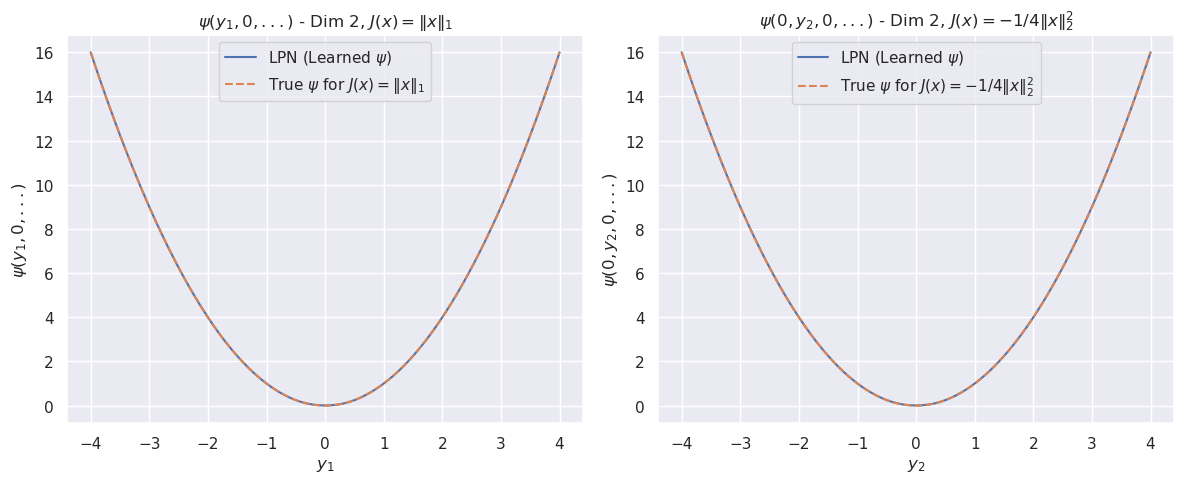

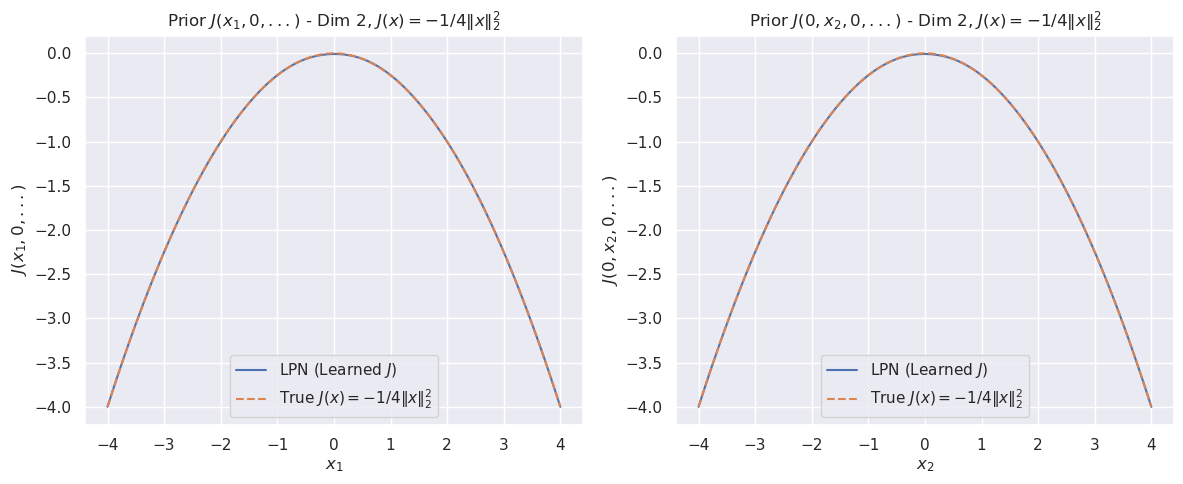

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-1.3276,  3.5265],
        [-7.9815, -3.1601],
        [-5.6533, -6.5275],
        ...,
        [-5.3504,  1.8899],
        [-6.9107,  2.5521],
        [ 1.5264, -4.2296]], device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 160.29014587402344
iteration 0 loss 3918.5


iteration 500 loss 6.373700141906738


iteration 1000 loss 0.7655075192451477


iteration 1500 loss 0.06715037673711777


iteration 2000 loss 0.02300828881561756


iteration 2500 loss 0.012745090760290623


iteration 3000 loss 0.00777942780405283


iteration 3500 loss 0.004836604930460453


iteration 4000 loss 0.009295319207012653


iteration 4500 loss 0.003965034615248442


iteration 5000 loss 3.208684206008911


iteration 5500 loss 0.003658108878880739


iteration 6000 loss 0.028469784185290337


iteration 6500 loss 0.0018960624001920223


iteration 7000 loss 0.0017824932001531124


iteration 7500 loss 0.0018137049628421664


iteration 8000 loss 0.0011631525121629238


iteration 8500 loss 0.001578119001351297


iteration 9000 loss 0.0009748429874889553


iteration 9500 loss 0.0011426275596022606


iteration 10000 loss 0.28019312024116516


iteration 10500 loss 0.0007916505564935505


iteration 11000 loss 0.0010425953660160303


iteration 11500 loss 0.0005705475923605263


iteration 12000 loss 0.0006596377352252603


iteration 12500 loss 0.004892636090517044


iteration 13000 loss 0.0004782931646332145


iteration 13500 loss 0.0005777932819910347


iteration 14000 loss 0.000402744859457016


iteration 14500 loss 0.0005555613315664232


iteration 15000 loss 0.0003706549177877605


iteration 15500 loss 0.0005039911484345794


iteration 16000 loss 0.0003411250072531402


iteration 16500 loss 0.0004428902466315776


iteration 17000 loss 0.00031339057022705674


iteration 17500 loss 0.003785163862630725


iteration 18000 loss 0.0003467114001978189


iteration 18500 loss 0.0002707000821828842


iteration 19000 loss 0.00022175125195644796


iteration 19500 loss 0.0004110326699446887


iteration 20000 loss 0.00024707024567760527


iteration 20500 loss 0.00020241593301761895


iteration 21000 loss 0.0013497472973540425


iteration 21500 loss 0.00025034413556568325


iteration 22000 loss 0.00019993007299490273


iteration 22500 loss 0.00016696142847649753


iteration 23000 loss 0.00045251016854308546


iteration 23500 loss 0.0001980622619157657


iteration 24000 loss 0.0001645455922698602


iteration 24500 loss 0.00013536546612158418


iteration 25000 loss 0.0011726412922143936


iteration 25500 loss 0.00021251158614177257


iteration 26000 loss 0.00015444633027072996


iteration 26500 loss 0.00013135242625139654


iteration 27000 loss 0.00011936653754673898


iteration 27500 loss 0.13087721168994904


iteration 28000 loss 0.0003084988857153803


iteration 28500 loss 0.00020214534015394747


iteration 29000 loss 0.0001423838548362255


iteration 29500 loss 0.00012338711530901492


iteration 30000 loss 0.00010625361028360203


iteration 30500 loss 9.201165084959939e-05


iteration 31000 loss 0.002407661871984601


iteration 31500 loss 0.0003014724643435329


iteration 32000 loss 0.00021596848091576248


iteration 32500 loss 0.0001447303220629692


iteration 33000 loss 0.00014725067012477666


iteration 33500 loss 0.00011680942407110706


iteration 34000 loss 0.0001100506997318007


iteration 34500 loss 0.00010185900464421138


iteration 35000 loss 9.300201782025397e-05


iteration 35500 loss 8.903122215997428e-05


iteration 36000 loss 8.37316838442348e-05


iteration 36500 loss 8.658306614961475e-05


iteration 37000 loss 0.0004101654340047389


iteration 37500 loss 6.161508645163849e-05


iteration 38000 loss 7.669385377084836e-05


iteration 38500 loss 0.00023390873684547842


iteration 39000 loss 0.009840159676969051


iteration 39500 loss 0.002731051528826356


iteration 40000 loss 0.0005704766372218728


iteration 40500 loss 0.002407962456345558


iteration 41000 loss 0.00020008468709420413


iteration 41500 loss 0.0001861821219790727


iteration 42000 loss 0.00016129776486195624


iteration 42500 loss 0.00011225130583625287


iteration 43000 loss 9.587885142536834e-05


iteration 43500 loss 9.036759729497135e-05


iteration 44000 loss 8.787017577560619e-05


iteration 44500 loss 8.564924792153761e-05


iteration 45000 loss 8.046667790040374e-05


iteration 45500 loss 7.806481880834326e-05


iteration 46000 loss 0.00010252197535010055


iteration 46500 loss 5.0303857278777286e-05


iteration 47000 loss 6.037356797605753e-05


iteration 47500 loss 6.858661072328687e-05


iteration 48000 loss 6.95220660418272e-05


iteration 48500 loss 8.087671449175104e-05


iteration 49000 loss 0.0002170171937905252


iteration 49500 loss 4.930477007292211e-05


iteration 50000 loss 5.1446830184431747e-05


iteration 50500 loss 5.79566003580112e-05


iteration 51000 loss 9.780554682947695e-05


iteration 51500 loss 4.8917609092313796e-05


iteration 52000 loss 6.271896563703194e-05


iteration 52500 loss 0.00013419444439932704


iteration 53000 loss 5.095902088214643e-05


iteration 53500 loss 6.46485059405677e-05


iteration 54000 loss 0.00010714645031839609


iteration 54500 loss 5.090427293907851e-05


iteration 55000 loss 5.236127253738232e-05


iteration 55500 loss 7.407012890325859e-05


iteration 56000 loss 4.52275198767893e-05


iteration 56500 loss 5.3069237765157595e-05


iteration 57000 loss 7.138061482692137e-05


iteration 57500 loss 4.440534030436538e-05


iteration 58000 loss 4.70915729238186e-05


iteration 58500 loss 6.451638910220936e-05


iteration 59000 loss 4.233551226207055e-05


iteration 59500 loss 4.5644403144251555e-05


iteration 60000 loss 5.398445136961527e-05


iteration 60500 loss 0.004289048723876476


iteration 61000 loss 4.376115248305723e-05


iteration 61500 loss 5.8701345551526174e-05


iteration 62000 loss 3.906277925125323e-05


iteration 62500 loss 4.436350354808383e-05


iteration 63000 loss 8.549681660952047e-05


iteration 63500 loss 3.91757239412982e-05


iteration 64000 loss 4.87212382722646e-05


iteration 64500 loss 0.00014605662727262825


iteration 65000 loss 3.867692794301547e-05


iteration 65500 loss 4.198107490083203e-05


iteration 66000 loss 4.6350498450919986e-05


iteration 66500 loss 0.00027905163005925715


iteration 67000 loss 3.972267950302921e-05


iteration 67500 loss 4.739947326015681e-05


iteration 68000 loss 0.3362256586551666


iteration 68500 loss 4.019202970084734e-05


iteration 69000 loss 5.404984767665155e-05


iteration 69500 loss 3.6330271541373804e-05


iteration 70000 loss 4.1105147829512134e-05


iteration 70500 loss 6.409958587028086e-05


iteration 71000 loss 3.677517088362947e-05


iteration 71500 loss 4.2328589188400656e-05


iteration 72000 loss 0.0001670322089921683


iteration 72500 loss 3.618435948737897e-05


iteration 73000 loss 4.192048072582111e-05


iteration 73500 loss 0.00021458191622514278


iteration 74000 loss 3.4973243600688875e-05


iteration 74500 loss 3.867307896143757e-05


iteration 75000 loss 6.464902253355831e-05


iteration 75500 loss 3.469456351012923e-05


iteration 76000 loss 4.086055196239613e-05


iteration 76500 loss 9.084457269636914e-05


iteration 77000 loss 3.344313518027775e-05


iteration 77500 loss 3.6934543459210545e-05


iteration 78000 loss 4.7090430598473176e-05


iteration 78500 loss 3.353371357661672e-05


iteration 79000 loss 3.543816274031997e-05


iteration 79500 loss 3.9281319914152846e-05


iteration 80000 loss 3.18545316986274e-05


iteration 80500 loss 3.476937490631826e-05


iteration 81000 loss 3.849946369882673e-05


iteration 81500 loss 3.128747994196601e-05


iteration 82000 loss 3.4319222322665155e-05


iteration 82500 loss 4.386727960081771e-05


iteration 83000 loss 3.132108031422831e-05


iteration 83500 loss 3.459117215243168e-05


iteration 84000 loss 0.008018620312213898


iteration 84500 loss 3.156011734972708e-05


iteration 85000 loss 3.929556260118261e-05


iteration 85500 loss 3.0153214538586326e-05


iteration 86000 loss 3.346585071994923e-05


iteration 86500 loss 9.111285180551931e-05


iteration 87000 loss 2.945239430118818e-05


iteration 87500 loss 2.9345774237299338e-05


iteration 88000 loss 3.1569743441650644e-05


iteration 88500 loss 7.879902113927528e-05


iteration 89000 loss 2.8583594030351378e-05


iteration 89500 loss 3.0615181458415464e-05


iteration 90000 loss 4.282937152311206e-05


iteration 90500 loss 2.836921703419648e-05


iteration 91000 loss 3.161694257869385e-05


iteration 91500 loss 0.004107614979147911


iteration 92000 loss 2.7998952646157704e-05


iteration 92500 loss 3.0407565645873547e-05


iteration 93000 loss 0.0013315792893990874


iteration 93500 loss 2.7078684070147574e-05


iteration 94000 loss 2.7656356905936264e-05


iteration 94500 loss 2.8679905881290324e-05


iteration 95000 loss 3.702889080159366e-05


iteration 95500 loss 2.6390242055640556e-05


iteration 96000 loss 2.8784572350559756e-05


iteration 96500 loss 0.009389463812112808


iteration 97000 loss 2.643072912178468e-05


iteration 97500 loss 2.871213473554235e-05


iteration 98000 loss 0.000979095813818276


iteration 98500 loss 2.6434603569214232e-05


iteration 99000 loss 3.032533459190745e-05


iteration 99500 loss 2.5144707251456566e-05


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 2.673619928827975e-05


iteration 100500 loss 2.6288151275366545e-05


iteration 101000 loss 2.58109957940178e-05


iteration 101500 loss 2.5300842025899328e-05


iteration 102000 loss 2.4752413082751445e-05


iteration 102500 loss 2.4156252038665116e-05


iteration 103000 loss 2.3490129024139605e-05


iteration 103500 loss 2.2700016415910795e-05


iteration 104000 loss 2.1903755623498e-05


iteration 104500 loss 2.0972800484742038e-05


iteration 105000 loss 2.156880873371847e-05


iteration 105500 loss 1.9407754734857008e-05


iteration 106000 loss 1.8656282918527722e-05


iteration 106500 loss 1.8160357285523787e-05


iteration 107000 loss 1.7573871446074918e-05


iteration 107500 loss 1.7062075130525045e-05


iteration 108000 loss 1.6588819562457502e-05


iteration 108500 loss 1.619895556359552e-05


iteration 109000 loss 1.5776829968672246e-05


iteration 109500 loss 1.540861740068067e-05


iteration 110000 loss 1.5048256500449497e-05


iteration 110500 loss 1.4663752153865062e-05


iteration 111000 loss 1.4364701200975105e-05


iteration 111500 loss 1.40794245453435e-05


iteration 112000 loss 1.3765524272457696e-05


iteration 112500 loss 1.3514172678696923e-05


iteration 113000 loss 1.3265597772260662e-05


iteration 113500 loss 1.307563616137486e-05


iteration 114000 loss 1.2789246284228284e-05


iteration 114500 loss 1.2588783647515811e-05


iteration 115000 loss 1.2379758118186146e-05


iteration 115500 loss 1.2399409570207354e-05


iteration 116000 loss 0.0006349639152176678


iteration 116500 loss 1.1762000212911516e-05


iteration 117000 loss 1.1584391359065194e-05


iteration 117500 loss 1.1413678294047713e-05


iteration 118000 loss 1.124640039051883e-05


iteration 118500 loss 1.1085509868280496e-05


iteration 119000 loss 1.0940218999166973e-05


iteration 119500 loss 1.5168294339673594e-05


iteration 120000 loss 0.00015488630742765963


iteration 120500 loss 1.0485848179087043e-05


iteration 121000 loss 1.035616787703475e-05


iteration 121500 loss 1.0229712643194944e-05


iteration 122000 loss 1.0109857612405904e-05


iteration 122500 loss 9.994874744734261e-06


iteration 123000 loss 0.001365182688459754


iteration 123500 loss 9.745871466293465e-06


iteration 124000 loss 9.626442079024855e-06


iteration 124500 loss 9.517615580989514e-06


iteration 125000 loss 9.406614481122233e-06


iteration 125500 loss 9.298709301219787e-06


iteration 126000 loss 9.195933671435341e-06


iteration 126500 loss 9.1016763690277e-06


iteration 127000 loss 9.007769222080242e-06


iteration 127500 loss 8.912843441066798e-06


iteration 128000 loss 8.824586984701455e-06


iteration 128500 loss 8.8859642346506e-06


iteration 129000 loss 8.87044552655425e-06


iteration 129500 loss 8.574013008910697e-06


iteration 130000 loss 8.488532330375165e-06


iteration 130500 loss 8.397890269407071e-06


iteration 131000 loss 8.316274943354074e-06


iteration 131500 loss 8.240082934207749e-06


iteration 132000 loss 8.164249265973922e-06


iteration 132500 loss 8.088529284577817e-06


iteration 133000 loss 8.016821993805934e-06


iteration 133500 loss 7.949225619086064e-06


iteration 134000 loss 7.881971214374062e-06


iteration 134500 loss 7.815046956238803e-06


iteration 135000 loss 7.746305527689401e-06


iteration 135500 loss 7.683825060667004e-06


iteration 136000 loss 7.61942192184506e-06


iteration 136500 loss 7.559292043879395e-06


iteration 137000 loss 7.501776508433977e-06


iteration 137500 loss 7.446178642567247e-06


iteration 138000 loss 7.3885207712010015e-06


iteration 138500 loss 7.3279920798086096e-06


iteration 139000 loss 7.27178894521785e-06


iteration 139500 loss 7.217052370833699e-06


iteration 140000 loss 7.1628687692282256e-06


iteration 140500 loss 7.107377768988954e-06


iteration 141000 loss 7.05407092027599e-06


iteration 141500 loss 7.000298410275718e-06


iteration 142000 loss 6.949922862986568e-06


iteration 142500 loss 6.900554581079632e-06


iteration 143000 loss 6.851185844425345e-06


iteration 143500 loss 3.874754111166112e-05


iteration 144000 loss 1.0137913704966195e-05


iteration 144500 loss 6.76821218803525e-06


iteration 145000 loss 6.66343930788571e-06


iteration 145500 loss 6.61521835354506e-06


iteration 146000 loss 6.649554507021094e-06


iteration 146500 loss 6.532610768772429e-06


iteration 147000 loss 6.4880332502070814e-06


iteration 147500 loss 6.444109658332309e-06


iteration 148000 loss 6.401078280759975e-06


iteration 148500 loss 6.358996415656293e-06


iteration 149000 loss 6.318658961390611e-06


iteration 149500 loss 6.277394277276471e-06


iteration 150000 loss 6.238944479264319e-06


iteration 150500 loss 0.0001360167225357145


iteration 151000 loss 9.975100510928314e-06


iteration 151500 loss 0.00013123643293511122


iteration 152000 loss 0.00013048810069449246


iteration 152500 loss 6.167476385599002e-06


iteration 153000 loss 6.017402483848855e-06


iteration 153500 loss 5.9814442465722095e-06


iteration 154000 loss 5.986427368043223e-06


iteration 154500 loss 5.9163380683457945e-06


iteration 155000 loss 5.877356215933105e-06


iteration 155500 loss 8.376458026759792e-06


iteration 156000 loss 5.81267067900626e-06


iteration 156500 loss 5.7786428442341276e-06


iteration 157000 loss 5.744984264310915e-06


iteration 157500 loss 5.712944130209507e-06


iteration 158000 loss 5.682689788955031e-06


iteration 158500 loss 5.653158495988464e-06


iteration 159000 loss 5.6226922424684744e-06


iteration 159500 loss 5.592204615822993e-06


iteration 160000 loss 5.5614468692510854e-06


iteration 160500 loss 5.533607236429816e-06


iteration 161000 loss 5.504523414856521e-06


iteration 161500 loss 6.415352800104301e-06


iteration 162000 loss 5.5146406339190435e-06


iteration 162500 loss 5.4227143664320465e-06


iteration 163000 loss 5.393012543208897e-06


iteration 163500 loss 5.364615390135441e-06


iteration 164000 loss 5.337670700100716e-06


iteration 164500 loss 5.311100267135771e-06


iteration 165000 loss 5.2847594815830234e-06


iteration 165500 loss 5.259155386738712e-06


iteration 166000 loss 1.807826447475236e-05


iteration 166500 loss 5.2207701628503855e-06


iteration 167000 loss 5.188666364119854e-06


iteration 167500 loss 5.162156867299927e-06


iteration 168000 loss 5.138667347637238e-06


iteration 168500 loss 5.114668510941556e-06


iteration 169000 loss 5.089011665404541e-06


iteration 169500 loss 5.062507625552826e-06


iteration 170000 loss 5.039355528424494e-06


iteration 170500 loss 5.014377165935002e-06


iteration 171000 loss 4.992950380255934e-06


iteration 171500 loss 4.969854671799112e-06


iteration 172000 loss 4.947733941662591e-06


iteration 172500 loss 4.926368546875892e-06


iteration 173000 loss 4.9063446567743085e-06


iteration 173500 loss 4.884470854449319e-06


iteration 174000 loss 4.861880825046683e-06


iteration 174500 loss 4.8386227717855945e-06


iteration 175000 loss 4.817836725123925e-06


iteration 175500 loss 4.796238954440923e-06


iteration 176000 loss 7.148853910621256e-05


iteration 176500 loss 4.7596381591574755e-06


iteration 177000 loss 4.739874384540599e-06


iteration 177500 loss 4.72120200356585e-06


iteration 178000 loss 4.699031705968082e-06


iteration 178500 loss 4.677044671552721e-06


iteration 179000 loss 4.6556037887057755e-06


iteration 179500 loss 4.6347558964043856e-06


iteration 180000 loss 4.621012521965895e-06


iteration 180500 loss 4.597357929014834e-06


iteration 181000 loss 7.407675639115041e-06


iteration 181500 loss 4.560802608466474e-06


iteration 182000 loss 4.5394695007416885e-06


iteration 182500 loss 4.525453277892666e-06


iteration 183000 loss 4.503989202930825e-06


iteration 183500 loss 4.484665623749606e-06


iteration 184000 loss 4.4871803766000085e-06


iteration 184500 loss 4.451133008842589e-06


iteration 185000 loss 4.431905381352408e-06


iteration 185500 loss 0.000913458236027509


iteration 186000 loss 4.713273938250495e-06


iteration 186500 loss 4.381415237730835e-06


iteration 187000 loss 4.362470008345554e-06


iteration 187500 loss 4.349798928160453e-06


iteration 188000 loss 4.3293066482874565e-06


iteration 188500 loss 1.0782367098727264e-05


iteration 189000 loss 4.298321982787456e-06


iteration 189500 loss 4.2804258555406705e-06


iteration 190000 loss 4.455301223060815e-06


iteration 190500 loss 4.249882749718381e-06


iteration 191000 loss 4.231909770169295e-06


iteration 191500 loss 4.220499704388203e-06


iteration 192000 loss 4.201874617137946e-06


iteration 192500 loss 4.185555098956684e-06


iteration 193000 loss 4.179244115221081e-06


iteration 193500 loss 4.986209205526393e-06


iteration 194000 loss 4.142621946812142e-06


iteration 194500 loss 4.1263087950937916e-06


iteration 195000 loss 4.110815098101739e-06


iteration 195500 loss 4.220611572236521e-06


iteration 196000 loss 4.083543444721727e-06


iteration 196500 loss 1.6512805814272724e-05


iteration 197000 loss 4.055699719174299e-06


iteration 197500 loss 4.03945887228474e-06


iteration 198000 loss 4.101348622498335e-06


iteration 198500 loss 4.014413661934668e-06


iteration 199000 loss 3.999690761702368e-06


iteration 199500 loss 7.235307748487685e-06


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 3.972963895648718e-06


iteration 200500 loss 3.970889338233974e-06


iteration 201000 loss 3.9684273360762745e-06


iteration 201500 loss 3.965032192354556e-06


iteration 202000 loss 3.961195943702478e-06


iteration 202500 loss 3.9561309677083045e-06


iteration 203000 loss 3.9497308534919284e-06


iteration 203500 loss 3.941464456147514e-06


iteration 204000 loss 3.9309666135523e-06


iteration 204500 loss 3.917970389011316e-06


iteration 205000 loss 3.9023234421620145e-06


iteration 205500 loss 3.8882089938852005e-06


iteration 206000 loss 3.874508820445044e-06


iteration 206500 loss 3.8613770811934955e-06


iteration 207000 loss 3.850997927656863e-06


iteration 207500 loss 3.834863946394762e-06


iteration 208000 loss 4.217803052597446e-06


iteration 208500 loss 3.806056383837131e-06


iteration 209000 loss 3.7942229482723633e-06


iteration 209500 loss 3.7820391298737377e-06


iteration 210000 loss 3.7685229017370148e-06


iteration 210500 loss 3.755997795451549e-06


iteration 211000 loss 3.74312753592676e-06


iteration 211500 loss 3.7323470678529702e-06


iteration 212000 loss 3.719092774190358e-06


iteration 212500 loss 3.708009217007202e-06


iteration 213000 loss 3.6959629596822197e-06


iteration 213500 loss 3.6842329791397788e-06


iteration 214000 loss 3.673706032714108e-06


iteration 214500 loss 3.6739954794029472e-06


iteration 215000 loss 3.6495430322247557e-06


iteration 215500 loss 3.637286226876313e-06


iteration 216000 loss 3.624725195550127e-06


iteration 216500 loss 3.614745992308599e-06


iteration 217000 loss 3.603589448175626e-06


iteration 217500 loss 3.5920463687943993e-06


iteration 218000 loss 3.5810187455354026e-06


iteration 218500 loss 3.5703080811799737e-06


iteration 219000 loss 3.5605175980890635e-06


iteration 219500 loss 3.5486511933413567e-06


iteration 220000 loss 3.5390371522225905e-06


iteration 220500 loss 3.5273574212624226e-06


iteration 221000 loss 3.5175366974726785e-06


iteration 221500 loss 3.506827169985627e-06


iteration 222000 loss 3.4970469187101116e-06


iteration 222500 loss 3.4852928365580738e-06


iteration 223000 loss 3.4765585041895974e-06


iteration 223500 loss 3.466033831500681e-06


iteration 224000 loss 3.456053036643425e-06


iteration 224500 loss 3.446687969699269e-06


iteration 225000 loss 3.436284032432013e-06


iteration 225500 loss 3.4266779493918875e-06


iteration 226000 loss 3.416564140934497e-06


iteration 226500 loss 3.407607891858788e-06


iteration 227000 loss 3.397398359084036e-06


iteration 227500 loss 3.3867504498630296e-06


iteration 228000 loss 3.378538622200722e-06


iteration 228500 loss 3.3690496366034495e-06


iteration 229000 loss 3.359478569109342e-06


iteration 229500 loss 3.3495086881885072e-06


iteration 230000 loss 3.341101773912669e-06


iteration 230500 loss 3.3318481200694805e-06


iteration 231000 loss 3.322786369608366e-06


iteration 231500 loss 3.5117282095598057e-06


iteration 232000 loss 3.3037188131856965e-06


iteration 232500 loss 3.2949574233498424e-06


iteration 233000 loss 3.2853311040526023e-06


iteration 233500 loss 3.27704765368253e-06


iteration 234000 loss 3.2913208087848034e-06


iteration 234500 loss 3.2594825825071894e-06


iteration 235000 loss 3.250331701565301e-06


iteration 235500 loss 3.2411139727628324e-06


iteration 236000 loss 3.232844846934313e-06


iteration 236500 loss 3.2853245102160145e-06


iteration 237000 loss 3.2159364309336524e-06


iteration 237500 loss 3.21514266943268e-06


iteration 238000 loss 3.1993447464628844e-06


iteration 238500 loss 3.390846359252464e-06


iteration 239000 loss 3.1833312732487684e-06


iteration 239500 loss 3.174778385073296e-06


iteration 240000 loss 3.1673266676079948e-06


iteration 240500 loss 3.159741254421533e-06


iteration 241000 loss 3.151507144139032e-06


iteration 241500 loss 3.1436536573892226e-06


iteration 242000 loss 3.1357735679193866e-06


iteration 242500 loss 3.128568323518266e-06


iteration 243000 loss 3.1196134386846097e-06


iteration 243500 loss 3.1134693472267827e-06


iteration 244000 loss 3.1053984912432497e-06


iteration 244500 loss 3.098132083323435e-06


iteration 245000 loss 3.0907247037248453e-06


iteration 245500 loss 3.0832070478936657e-06


iteration 246000 loss 3.076325356232701e-06


iteration 246500 loss 5.922475338593358e-06


iteration 247000 loss 3.061652932956349e-06


iteration 247500 loss 3.054282842640532e-06


iteration 248000 loss 3.0474586765194545e-06


iteration 248500 loss 3.0404783046833472e-06


iteration 249000 loss 3.155299282298074e-06


iteration 249500 loss 3.026691047125496e-06


iteration 250000 loss 3.0190574307198403e-06


iteration 250500 loss 3.0125772809697082e-06


iteration 251000 loss 3.00570923172927e-06


iteration 251500 loss 2.9987031666678376e-06


iteration 252000 loss 2.9924603950348683e-06


iteration 252500 loss 2.9847174118913244e-06


iteration 253000 loss 2.9792577151965816e-06


iteration 253500 loss 2.9723491934419144e-06


iteration 254000 loss 2.9655413982254686e-06


iteration 254500 loss 2.9595757951028645e-06


iteration 255000 loss 2.9517839266191004e-06


iteration 255500 loss 2.9463633381965337e-06


iteration 256000 loss 2.9397158414212754e-06


iteration 256500 loss 2.933202267740853e-06


iteration 257000 loss 2.9269824608491035e-06


iteration 257500 loss 3.1849785955273546e-06


iteration 258000 loss 2.914512378993095e-06


iteration 258500 loss 2.9074144549667835e-06


iteration 259000 loss 2.9016873668297194e-06


iteration 259500 loss 2.8955787456652615e-06


iteration 260000 loss 2.892402562792995e-06


iteration 260500 loss 2.8832935186073883e-06


iteration 261000 loss 2.876570079024532e-06


iteration 261500 loss 2.8710419428534806e-06


iteration 262000 loss 2.8642723464145092e-06


iteration 262500 loss 2.8584945539478213e-06


iteration 263000 loss 2.85163264379662e-06


iteration 263500 loss 2.846313464033301e-06


iteration 264000 loss 2.8405456760083325e-06


iteration 264500 loss 2.8346150884317467e-06


iteration 265000 loss 2.829254071912146e-06


iteration 265500 loss 2.822760052367812e-06


iteration 266000 loss 2.817514769049012e-06


iteration 266500 loss 2.8111196570534958e-06


iteration 267000 loss 2.805878011713503e-06


iteration 267500 loss 2.8001470582239563e-06


iteration 268000 loss 2.7943071927438723e-06


iteration 268500 loss 2.788774963846663e-06


iteration 269000 loss 2.7837572815769818e-06


iteration 269500 loss 2.777686631816323e-06


iteration 270000 loss 2.8962358555872925e-06


iteration 270500 loss 2.765851377262152e-06


iteration 271000 loss 2.7601888632489135e-06


iteration 271500 loss 2.754738488874864e-06


iteration 272000 loss 2.7487537863635225e-06


iteration 272500 loss 2.743547611316899e-06


iteration 273000 loss 2.739191813816433e-06


iteration 273500 loss 2.733120709308423e-06


iteration 274000 loss 2.727322907958296e-06


iteration 274500 loss 2.7223384222452296e-06


iteration 275000 loss 2.717633378779283e-06


iteration 275500 loss 2.551580655563157e-05


iteration 276000 loss 2.707163275772473e-06


iteration 276500 loss 2.701693347262335e-06


iteration 277000 loss 2.696764113352401e-06


iteration 277500 loss 2.6909629013971426e-06


iteration 278000 loss 2.6860382149607176e-06


iteration 278500 loss 2.681097839740687e-06


iteration 279000 loss 2.675758196346578e-06


iteration 279500 loss 2.6708439690992236e-06


iteration 280000 loss 2.6655420697352383e-06


iteration 280500 loss 2.660383188413107e-06


iteration 281000 loss 2.655466232681647e-06


iteration 281500 loss 2.6507891561777797e-06


iteration 282000 loss 9.223800589097664e-06


iteration 282500 loss 2.640622369654011e-06


iteration 283000 loss 2.929878064605873e-06


iteration 283500 loss 2.6309082841180498e-06


iteration 284000 loss 2.625262368383119e-06


iteration 284500 loss 2.6206098482361995e-06


iteration 285000 loss 2.8926342565682717e-06


iteration 285500 loss 2.6112909381481586e-06


iteration 286000 loss 1.1650388842099346e-05


iteration 286500 loss 2.601354481157614e-06


iteration 287000 loss 2.5995418582169805e-06


iteration 287500 loss 2.5919398467522115e-06


iteration 288000 loss 2.6021264147857437e-06


iteration 288500 loss 2.5823428586591035e-06


iteration 289000 loss 2.5797926355153322e-06


iteration 289500 loss 2.5730191737238783e-06


iteration 290000 loss 2.5679580630821874e-06


iteration 290500 loss 2.56396310760465e-06


iteration 291000 loss 2.558984078859794e-06


iteration 291500 loss 2.5546705728629604e-06


iteration 292000 loss 2.550110821175622e-06


iteration 292500 loss 2.5456174626015127e-06


iteration 293000 loss 2.540933110140031e-06


iteration 293500 loss 2.536460669944063e-06


iteration 294000 loss 2.5322487999801524e-06


iteration 294500 loss 2.5276672204199713e-06


iteration 295000 loss 2.5232834559574258e-06


iteration 295500 loss 2.518716883059824e-06


iteration 296000 loss 2.51422625296982e-06


iteration 296500 loss 2.5098331661865814e-06


iteration 297000 loss 2.505397560526035e-06


iteration 297500 loss 2.5011345314851496e-06


iteration 298000 loss 2.4971157017716905e-06


iteration 298500 loss 2.4925304842327023e-06


iteration 299000 loss 2.488344307494117e-06


iteration 299500 loss 2.4839091565809213e-06


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 2.4798305275908206e-06


iteration 300500 loss 2.4795417630230077e-06


iteration 301000 loss 2.479046997905243e-06


iteration 301500 loss 2.478439455444459e-06


iteration 302000 loss 2.4774985831754748e-06


iteration 302500 loss 2.4763114652159857e-06


iteration 303000 loss 2.474547500241897e-06


iteration 303500 loss 2.472444293744047e-06


iteration 304000 loss 2.4695921183592873e-06


iteration 304500 loss 2.466266323608579e-06


iteration 305000 loss 2.4614628273411654e-06


iteration 305500 loss 2.458001972627244e-06


iteration 306000 loss 2.453950401104521e-06


iteration 306500 loss 2.449754674671567e-06


iteration 307000 loss 2.4464461603201926e-06


iteration 307500 loss 2.4416881387878675e-06


iteration 308000 loss 2.43822410084249e-06


iteration 308500 loss 2.4346447844436625e-06


iteration 309000 loss 2.4303326426888816e-06


iteration 309500 loss 2.426676246614079e-06


iteration 310000 loss 2.423256091788062e-06


iteration 310500 loss 2.419124029984232e-06


iteration 311000 loss 2.415231392660644e-06


iteration 311500 loss 2.4108708203129936e-06


iteration 312000 loss 2.4075834517134354e-06


iteration 312500 loss 2.4036087324930122e-06


iteration 313000 loss 2.4001035399123793e-06


iteration 313500 loss 2.3964191768754972e-06


iteration 314000 loss 2.391972429904854e-06


iteration 314500 loss 2.387964968875167e-06


iteration 315000 loss 2.3849534045439214e-06


iteration 315500 loss 2.380846126470715e-06


iteration 316000 loss 2.3769630388414953e-06


iteration 316500 loss 2.3738323307043174e-06


iteration 317000 loss 2.3704169507254846e-06


iteration 317500 loss 2.3658162717765663e-06


iteration 318000 loss 2.3646550744160777e-06


iteration 318500 loss 2.3579798380524153e-06


iteration 319000 loss 2.354147682126495e-06


iteration 319500 loss 2.3499835606344277e-06


iteration 320000 loss 2.346330802538432e-06


iteration 320500 loss 2.3427819542121142e-06


iteration 321000 loss 2.339608045076602e-06


iteration 321500 loss 2.3357217742159264e-06


iteration 322000 loss 2.3321297248912742e-06


iteration 322500 loss 2.328857817701646e-06


iteration 323000 loss 2.3249931473401375e-06


iteration 323500 loss 2.3209404389490373e-06


iteration 324000 loss 2.3176485228759702e-06


iteration 324500 loss 2.314887979082414e-06


iteration 325000 loss 2.3110121674108086e-06


iteration 325500 loss 2.3066818357619923e-06


iteration 326000 loss 2.3036245693219826e-06


iteration 326500 loss 2.30038381232589e-06


iteration 327000 loss 2.2965950847719796e-06


iteration 327500 loss 2.293475745318574e-06


iteration 328000 loss 2.2900815110915573e-06


iteration 328500 loss 2.2863650883664377e-06


iteration 329000 loss 2.2823871859145584e-06


iteration 329500 loss 2.2791552964918083e-06


iteration 330000 loss 2.276387476740638e-06


iteration 330500 loss 2.2725901089870604e-06


iteration 331000 loss 2.2686206193611724e-06


iteration 331500 loss 2.265753209940158e-06


iteration 332000 loss 2.261997224195511e-06


iteration 332500 loss 2.2589924810745288e-06


iteration 333000 loss 2.2556819203600753e-06


iteration 333500 loss 2.2521592200064333e-06


iteration 334000 loss 2.2486667603516253e-06


iteration 334500 loss 2.245645646326011e-06


iteration 335000 loss 2.2421015728468774e-06


iteration 335500 loss 2.2392723622033373e-06


iteration 336000 loss 2.2358394744514953e-06


iteration 336500 loss 2.2321269170788582e-06


iteration 337000 loss 2.2291615096037276e-06


iteration 337500 loss 2.2260508103499888e-06


iteration 338000 loss 2.2225360680749873e-06


iteration 338500 loss 2.2190238269104157e-06


iteration 339000 loss 2.216017946921056e-06


iteration 339500 loss 2.212619392594206e-06


iteration 340000 loss 2.217951760030701e-06


iteration 340500 loss 2.2062718016968574e-06


iteration 341000 loss 2.2033195818949025e-06


iteration 341500 loss 2.199697519245092e-06


iteration 342000 loss 2.1970226953271776e-06


iteration 342500 loss 2.194031139879371e-06


iteration 343000 loss 2.1910288978688186e-06


iteration 343500 loss 2.187637619499583e-06


iteration 344000 loss 2.18466084334068e-06


iteration 344500 loss 2.182143134632497e-06


iteration 345000 loss 2.178506520067458e-06


iteration 345500 loss 2.1758705770480447e-06


iteration 346000 loss 2.17287492887408e-06


iteration 346500 loss 2.169759909520508e-06


iteration 347000 loss 2.1675589323422173e-06


iteration 347500 loss 2.1642963474732824e-06


iteration 348000 loss 2.16127614294237e-06


iteration 348500 loss 2.1587243281828705e-06


iteration 349000 loss 2.1555233615799807e-06


iteration 349500 loss 2.152638444385957e-06


iteration 350000 loss 2.1496414319699397e-06


iteration 350500 loss 2.146684664694476e-06


iteration 351000 loss 2.1443379409902263e-06


iteration 351500 loss 2.1411965462903026e-06


iteration 352000 loss 2.1382145405368647e-06


iteration 352500 loss 2.1358414414862636e-06


iteration 353000 loss 2.132557938239188e-06


iteration 353500 loss 2.129508857251494e-06


iteration 354000 loss 2.1325797661120305e-06


iteration 354500 loss 2.124021875715698e-06


iteration 355000 loss 2.1208559246588266e-06


iteration 355500 loss 2.1180935618758667e-06


iteration 356000 loss 2.1148605355847394e-06


iteration 356500 loss 2.111837375196046e-06


iteration 357000 loss 2.1084342733956873e-06


iteration 357500 loss 2.1101179754623445e-06


iteration 358000 loss 2.1024425223004073e-06


iteration 358500 loss 2.0999264052079525e-06


iteration 359000 loss 2.096947810059646e-06


iteration 359500 loss 2.094222281812108e-06


iteration 360000 loss 2.091216174449073e-06


iteration 360500 loss 2.0886345737380907e-06


iteration 361000 loss 2.086093900288688e-06


iteration 361500 loss 2.0831671463383827e-06


iteration 362000 loss 2.080749027300044e-06


iteration 362500 loss 2.078193347188062e-06


iteration 363000 loss 2.1023083718318958e-06


iteration 363500 loss 2.0727111404994503e-06


iteration 364000 loss 2.069938773274771e-06


iteration 364500 loss 2.0673976450780174e-06


iteration 365000 loss 2.0649774796765996e-06


iteration 365500 loss 2.0619893348339247e-06


iteration 366000 loss 2.059539383481024e-06


iteration 366500 loss 2.056888888546382e-06


iteration 367000 loss 2.05421247301274e-06


iteration 367500 loss 2.0517504708550405e-06


iteration 368000 loss 2.048991291303537e-06


iteration 368500 loss 2.04618686439062e-06


iteration 369000 loss 2.043403810603195e-06


iteration 369500 loss 2.041072775682551e-06


iteration 370000 loss 2.038277671090327e-06


iteration 370500 loss 2.0359743757580873e-06


iteration 371000 loss 2.0335721728770295e-06


iteration 371500 loss 2.03078934646328e-06


iteration 372000 loss 2.028474909820943e-06


iteration 372500 loss 2.026091578954947e-06


iteration 373000 loss 2.0231805137882475e-06


iteration 373500 loss 2.0208801743137883e-06


iteration 374000 loss 2.0187355858070077e-06


iteration 374500 loss 2.0208474325045245e-06


iteration 375000 loss 2.0135471459070686e-06


iteration 375500 loss 2.0112977381359087e-06


iteration 376000 loss 2.008502178796334e-06


iteration 376500 loss 2.005958776862826e-06


iteration 377000 loss 2.003345571210957e-06


iteration 377500 loss 2.0012132608826505e-06


iteration 378000 loss 1.9985354811069556e-06


iteration 378500 loss 1.9961084944952745e-06


iteration 379000 loss 1.993694013435743e-06


iteration 379500 loss 1.991197450479376e-06


iteration 380000 loss 1.9889614577550674e-06


iteration 380500 loss 1.9858302948705386e-06


iteration 381000 loss 1.9840979348373367e-06


iteration 381500 loss 1.9818228338408517e-06


iteration 382000 loss 1.97904660126369e-06


iteration 382500 loss 1.9761614566959906e-06


iteration 383000 loss 1.974173301277915e-06


iteration 383500 loss 1.972099198610522e-06


iteration 384000 loss 1.9732835880859056e-06


iteration 384500 loss 1.9672477264975896e-06


iteration 385000 loss 1.964884631888708e-06


iteration 385500 loss 1.9624060314527014e-06


iteration 386000 loss 1.960400595635292e-06


iteration 386500 loss 1.957730319190887e-06


iteration 387000 loss 1.95536699720833e-06


iteration 387500 loss 1.9529279597918503e-06


iteration 388000 loss 1.9506271655700402e-06


iteration 388500 loss 1.948422777786618e-06


iteration 389000 loss 1.945814119608258e-06


iteration 389500 loss 1.943866891451762e-06


iteration 390000 loss 1.9413232621445786e-06


iteration 390500 loss 1.939192543432e-06


iteration 391000 loss 1.9369888377696043e-06


iteration 391500 loss 1.934184183483012e-06


iteration 392000 loss 1.932463646880933e-06


iteration 392500 loss 1.930220832946361e-06


iteration 393000 loss 1.9276756120234495e-06


iteration 393500 loss 1.9253614027547883e-06


iteration 394000 loss 1.923076297316584e-06


iteration 394500 loss 1.9207052446290618e-06


iteration 395000 loss 1.9185274595656665e-06


iteration 395500 loss 2.16145326703554e-06


iteration 396000 loss 1.9140936728945235e-06


iteration 396500 loss 1.9118397176498547e-06


iteration 397000 loss 1.9093283754045842e-06


iteration 397500 loss 1.907008481794037e-06


iteration 398000 loss 1.9046755141971516e-06


iteration 398500 loss 1.9027847883990034e-06


iteration 399000 loss 1.9001029158971505e-06


iteration 399500 loss 1.8983050722454209e-06


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 1.8961623027280439e-06


iteration 400500 loss 1.8959411818286753e-06


iteration 401000 loss 1.895676291496784e-06


iteration 401500 loss 1.8953211338157416e-06


iteration 402000 loss 1.8948433080367977e-06


iteration 402500 loss 1.894141178127029e-06


iteration 403000 loss 1.8932711327579455e-06


iteration 403500 loss 1.8921538185168174e-06


iteration 404000 loss 1.890624616862624e-06


iteration 404500 loss 1.8888858903665096e-06


iteration 405000 loss 1.8867006019718247e-06


iteration 405500 loss 1.8846466218747082e-06


iteration 406000 loss 1.8825697907232097e-06


iteration 406500 loss 1.8803715420290246e-06


iteration 407000 loss 1.878294710877526e-06


iteration 407500 loss 1.8762362969937385e-06


iteration 408000 loss 1.8741130816124496e-06


iteration 408500 loss 1.8720809293881757e-06


iteration 409000 loss 1.870180199148308e-06


iteration 409500 loss 1.8681920437302324e-06


iteration 410000 loss 1.8661386320673046e-06


iteration 410500 loss 1.8639038898982108e-06


iteration 411000 loss 1.8618740114106913e-06


iteration 411500 loss 1.8599005215946818e-06


iteration 412000 loss 1.8575541389509453e-06


iteration 412500 loss 1.855435584730003e-06


iteration 413000 loss 1.8534650507717743e-06


iteration 413500 loss 1.8513263739805552e-06


iteration 414000 loss 1.8493411744202604e-06


iteration 414500 loss 1.8471868088454357e-06


iteration 415000 loss 1.8453451957611833e-06


iteration 415500 loss 1.8432940578350099e-06


iteration 416000 loss 1.8412183635518886e-06


iteration 416500 loss 1.8393142227068893e-06


iteration 417000 loss 1.8371835039943107e-06


iteration 417500 loss 1.835253783610824e-06


iteration 418000 loss 1.833416490626405e-06


iteration 418500 loss 1.8312470047021634e-06


iteration 419000 loss 1.8295007748747594e-06


iteration 419500 loss 1.827416554078809e-06


iteration 420000 loss 1.8254226006320096e-06


iteration 420500 loss 1.8234485423818114e-06


iteration 421000 loss 1.8214429928775644e-06


iteration 421500 loss 1.81954010258778e-06


iteration 422000 loss 1.8174204114984605e-06


iteration 422500 loss 1.815809127947432e-06


iteration 423000 loss 1.8135970094590448e-06


iteration 423500 loss 1.8118597608918208e-06


iteration 424000 loss 1.8099146927852416e-06


iteration 424500 loss 1.8080036170431413e-06


iteration 425000 loss 1.8061175524053397e-06


iteration 425500 loss 1.8042662759398809e-06


iteration 426000 loss 1.8023240500042448e-06


iteration 426500 loss 1.8004974435825716e-06


iteration 427000 loss 1.798646508177626e-06


iteration 427500 loss 1.7966464156415896e-06


iteration 428000 loss 1.7949830635188846e-06


iteration 428500 loss 1.792958528312738e-06


iteration 429000 loss 1.791233103176637e-06


iteration 429500 loss 1.7892874666358694e-06


iteration 430000 loss 1.7874084505820065e-06


iteration 430500 loss 1.7856394833870581e-06


iteration 431000 loss 1.78371033143776e-06


iteration 431500 loss 1.7819467075241846e-06


iteration 432000 loss 1.7800865634853835e-06


iteration 432500 loss 1.778171508703963e-06


iteration 433000 loss 1.7763479718269082e-06


iteration 433500 loss 1.7745718423611834e-06


iteration 434000 loss 1.772642804098723e-06


iteration 434500 loss 1.7710543716020766e-06


iteration 435000 loss 1.7691038465272868e-06


iteration 435500 loss 1.7673741012913524e-06


iteration 436000 loss 1.765591264302202e-06


iteration 436500 loss 1.7638433291722322e-06


iteration 437000 loss 1.762043666531099e-06


iteration 437500 loss 1.7603397282073274e-06


iteration 438000 loss 1.7586522744750255e-06


iteration 438500 loss 1.7568770545040024e-06


iteration 439000 loss 1.7550378288433421e-06


iteration 439500 loss 1.753457013364823e-06


iteration 440000 loss 1.7515220633868012e-06


iteration 440500 loss 1.7500331068731612e-06


iteration 441000 loss 1.7480887208876084e-06


iteration 441500 loss 1.746435373206623e-06


iteration 442000 loss 1.7447567870476632e-06


iteration 442500 loss 1.7429418903702754e-06


iteration 443000 loss 1.7413098021279438e-06


iteration 443500 loss 1.739731374073017e-06


iteration 444000 loss 1.7376493133269832e-06


iteration 444500 loss 1.7361867321596947e-06


iteration 445000 loss 1.7343126046398538e-06


iteration 445500 loss 1.7328384274151176e-06


iteration 446000 loss 1.7310853763774503e-06


iteration 446500 loss 1.7294614735874347e-06


iteration 447000 loss 1.7276912558372715e-06


iteration 447500 loss 1.726087361930695e-06


iteration 448000 loss 1.7242989542864962e-06


iteration 448500 loss 1.7228256865564617e-06


iteration 449000 loss 1.721519197417365e-06


iteration 449500 loss 1.7192605810123496e-06


iteration 450000 loss 1.7174467075165012e-06


iteration 450500 loss 1.7160193692689063e-06


iteration 451000 loss 1.714059294499748e-06


iteration 451500 loss 1.7124434634752106e-06


iteration 452000 loss 1.7107184930864605e-06


iteration 452500 loss 1.7091222161980113e-06


iteration 453000 loss 1.7074378320103278e-06


iteration 453500 loss 1.705853264866164e-06


iteration 454000 loss 1.7042713125192677e-06


iteration 454500 loss 1.70263604104548e-06


iteration 455000 loss 1.700909820101515e-06


iteration 455500 loss 1.6992535165627487e-06


iteration 456000 loss 1.6978283383650705e-06


iteration 456500 loss 1.6962218296612264e-06


iteration 457000 loss 1.6944956087172613e-06


iteration 457500 loss 1.6929842558965902e-06


iteration 458000 loss 1.6912713363126386e-06


iteration 458500 loss 1.6899816728255246e-06


iteration 459000 loss 1.6882918316696305e-06


iteration 459500 loss 1.6867024896782823e-06


iteration 460000 loss 1.6851927284733392e-06


iteration 460500 loss 1.6835340375109809e-06


iteration 461000 loss 1.6819021766423248e-06


iteration 461500 loss 1.6802837308205198e-06


iteration 462000 loss 1.6788230823294725e-06


iteration 462500 loss 1.6770127331255935e-06


iteration 463000 loss 1.6755357137299143e-06


iteration 463500 loss 1.6738282511141733e-06


iteration 464000 loss 1.67246071214322e-06


iteration 464500 loss 1.6707494978618342e-06


iteration 465000 loss 1.6693963971192716e-06


iteration 465500 loss 1.6676767700118944e-06


iteration 466000 loss 1.666286379986559e-06


iteration 466500 loss 1.6647973097860813e-06


iteration 467000 loss 1.6630898471703404e-06


iteration 467500 loss 1.6615440472378395e-06


iteration 468000 loss 1.6600131402810803e-06


iteration 468500 loss 1.6584612012593425e-06


iteration 469000 loss 1.6569620129303075e-06


iteration 469500 loss 1.6554877220187336e-06


iteration 470000 loss 1.6538526779186213e-06


iteration 470500 loss 1.6525999626537669e-06


iteration 471000 loss 1.6508280396010377e-06


iteration 471500 loss 1.6495471300004283e-06


iteration 472000 loss 1.6478110183015815e-06


iteration 472500 loss 1.6464418877149e-06


iteration 473000 loss 1.6447379493911285e-06


iteration 473500 loss 1.6433151586170425e-06


iteration 474000 loss 1.6418786117355921e-06


iteration 474500 loss 1.640289610804757e-06


iteration 475000 loss 1.6389071788580623e-06


iteration 475500 loss 1.6372445088563836e-06


iteration 476000 loss 1.6359049368475098e-06


iteration 476500 loss 1.6342935396096436e-06


iteration 477000 loss 1.632954308661283e-06


iteration 477500 loss 1.6316901110258186e-06


iteration 478000 loss 1.6300897414112114e-06


iteration 478500 loss 1.6284087678286596e-06


iteration 479000 loss 1.6270588503175532e-06


iteration 479500 loss 1.6255036143775214e-06


iteration 480000 loss 1.6241966704910737e-06


iteration 480500 loss 1.6227779724431457e-06


iteration 481000 loss 1.6213077742577298e-06


iteration 481500 loss 1.6198945331780124e-06


iteration 482000 loss 1.6182722220037249e-06


iteration 482500 loss 1.6170541812243755e-06


iteration 483000 loss 1.615353085071547e-06


iteration 483500 loss 1.6140643310791347e-06


iteration 484000 loss 1.612484197721642e-06


iteration 484500 loss 1.6110521983137005e-06


iteration 485000 loss 1.6095489172585076e-06


iteration 485500 loss 1.608225147720077e-06


iteration 486000 loss 1.6069166122179013e-06


iteration 486500 loss 1.6053843410190893e-06


iteration 487000 loss 1.6039945194279426e-06


iteration 487500 loss 1.6025140894271317e-06


iteration 488000 loss 1.6012796777431504e-06


iteration 488500 loss 1.5998599565136828e-06


iteration 489000 loss 1.5985136769813835e-06


iteration 489500 loss 1.597089067217894e-06


iteration 490000 loss 1.5956054539856268e-06


iteration 490500 loss 1.5943297739795526e-06


iteration 491000 loss 1.592774879100034e-06


iteration 491500 loss 1.5916851907604723e-06


iteration 492000 loss 1.5902733139228076e-06


iteration 492500 loss 1.5889239648458897e-06


iteration 493000 loss 1.5876054249019944e-06


iteration 493500 loss 1.5859715176702593e-06


iteration 494000 loss 1.5848531802475918e-06


iteration 494500 loss 1.5833287534405827e-06


iteration 495000 loss 1.582061031513149e-06


iteration 495500 loss 1.5806837154741515e-06


iteration 496000 loss 1.5791773648743401e-06


iteration 496500 loss 1.5779178283992223e-06


iteration 497000 loss 1.576333033881383e-06


iteration 497500 loss 1.5752499393784092e-06


iteration 498000 loss 1.573538497723348e-06


iteration 498500 loss 1.5724608601885848e-06


iteration 499000 loss 1.5709872513980372e-06


iteration 499500 loss 1.569722599015222e-06


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


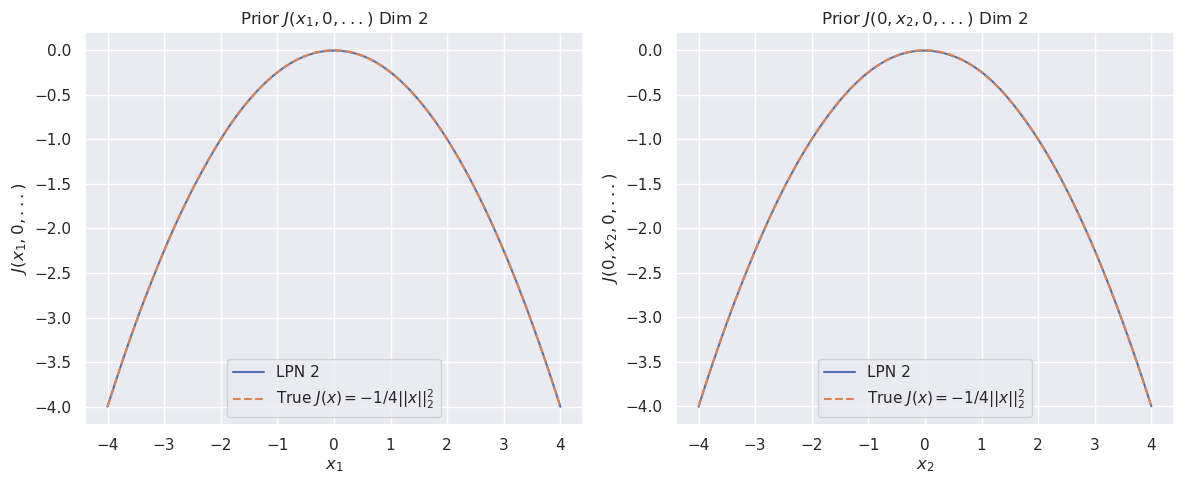

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)